

# Digital Assets Value Factor Analysis

This notebook explores the value factor in digital assets.

We will construct various cryptoasset valuation metrics proposed in the literature and compare their performance across a range of statistical tests and financial evaluation criteria.

To conduct this analysis, we will use **FactorLab**, an open-source python package we have created specifically for alpha and risk factor analysis. 

To install **FactorLab**:
`pip install factorlab`

In [46]:
# uncomment to install factorlab
# pip install factorlab

In [47]:
import pandas as pd
import numpy as np

from functools import partial
from typing import Optional, List, Callable
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
%matplotlib inline
from importlib import resources
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

from factorlab.value import Value
from factorlab.transform import Transform
from factorlab.data_viz import publish_table
from factorlab.time_series_analysis import linear_reg, adf, hurst, granger_causality
from factorlab.factor_analysis import Factor
from factorlab.performance import Performance
from factorlab.param_grid_search import *

# Collect Data

First, let's pull our value factor data csv files.

Data was gathered, cleaned and wrangled using **CryptoDataPy**, our open source python package. See the data wrangling notebooks for the data pre-processing code.

In [144]:
# data = pd.read_csv('../src/factorlab/datasets/data/value_factor_data.csv', index_col=[0,1], parse_dates=True)

In [145]:
df = pd.read_csv('../src/factorlab/datasets/data/crypto_market_data.csv', index_col=[0,1], parse_dates=True)
mktcap_df = pd.read_csv('../src/factorlab/datasets/data/crypto_mkt_cap.csv', index_col=[0,1], parse_dates=True)
oc_df = pd.read_csv('../src/factorlab/datasets/data/crypto_onchain_data.csv', index_col=[0,1], parse_dates=True)

In [146]:
# merge
oc_df = pd.concat([mktcap_df, oc_df], axis=1).sort_index()

## Compute Value Measures

We create an on-chain dataframe with all our clean on-chain data from which we can create value measures.

- Compute **Market value to Realized value MVRV ratio**

In [51]:
oc_df['mvrv'] = oc_df.mkt_cap / oc_df.mkt_cap_real

- Compute **addresses squared** for new and active addresses, and transaction counts, as per **Metcalfe's law**

In [52]:
# active addresses * mean transf value usd
oc_df['add_act_squared'] = oc_df.add_act ** 2
oc_df['add_new_squared'] = oc_df.add_new ** 2
oc_df['add_tot_squared'] = oc_df.add_tot ** 2
oc_df['tx_count_squared'] = oc_df.tx_count ** 2

- Compute an **adjusted transaction value** to reduce impact of large outlier transactions by multiplying average transfer value by transaction counts

In [53]:
oc_df['tfr_val_usd_adj'] = oc_df.tx_count * oc_df.tfr_val_mean_usd

- Compute **Network value to Transactions value NVT ratio**

In [54]:
oc_df['nvt'] = oc_df.mkt_cap / oc_df.tfr_val_usd
oc_df['nvt_adj'] = oc_df.mkt_cap / oc_df.tfr_val_usd_adj

# Data Exploration

We can now start with some simple exploratory analysis.


Converting our data into logs, we can establish which indicators have the highest correlation with market cap.

In [55]:
# correlations
np.log(oc_df).corr().mkt_cap.sort_values()

nvt_adj            -0.356334
nvt                -0.160856
supply_circ        -0.001201
mvrv                0.182408
tfr_count           0.294565
tfr_val_mean_usd    0.490472
hashrate            0.587205
diff_mean           0.612789
add_act             0.623010
add_act_squared     0.623010
tx_count            0.637112
tx_count_squared    0.637112
add_tot             0.747198
add_tot_squared     0.747198
add_new             0.781988
add_new_squared     0.781988
tfr_val_usd         0.843574
tfr_val_usd_adj     0.876917
mkt_cap_real        0.951861
mkt_cap_ff          0.969022
mkt_cap             1.000000
Name: mkt_cap, dtype: float64

Let's plot our indicators against market cap to get a sense of fit.

#### Aggregate Market Cap vs. On-chain Fundamentals

In [56]:
# plot data
plt_data = oc_df.copy()
plt_data = plt_data[['mkt_cap', 'mkt_cap_real', 'tfr_val_usd', 'tx_count_squared', 'add_act_squared', 'add_new_squared', 'add_tot', 'hashrate', 'diff_mean']].groupby('date').sum()

In [57]:
plot_df = np.log(plt_data[['mkt_cap', 'mkt_cap_real', 'tfr_val_usd', 'tx_count_squared', 'add_act_squared', 'add_new_squared', 'add_tot', 'hashrate', 'diff_mean']])
plot_df.columns = ['market_cap', 'market_cap_realized', 'transfer_value_usd', 'transactions_count', 'active_addresses', 'new_addresses', 'total_addresses', 'hashrate', 'difficulty']

In [58]:
# smooth network data
plot_df.iloc[:,2:] = plot_df.iloc[:,2:].ewm(30).mean()

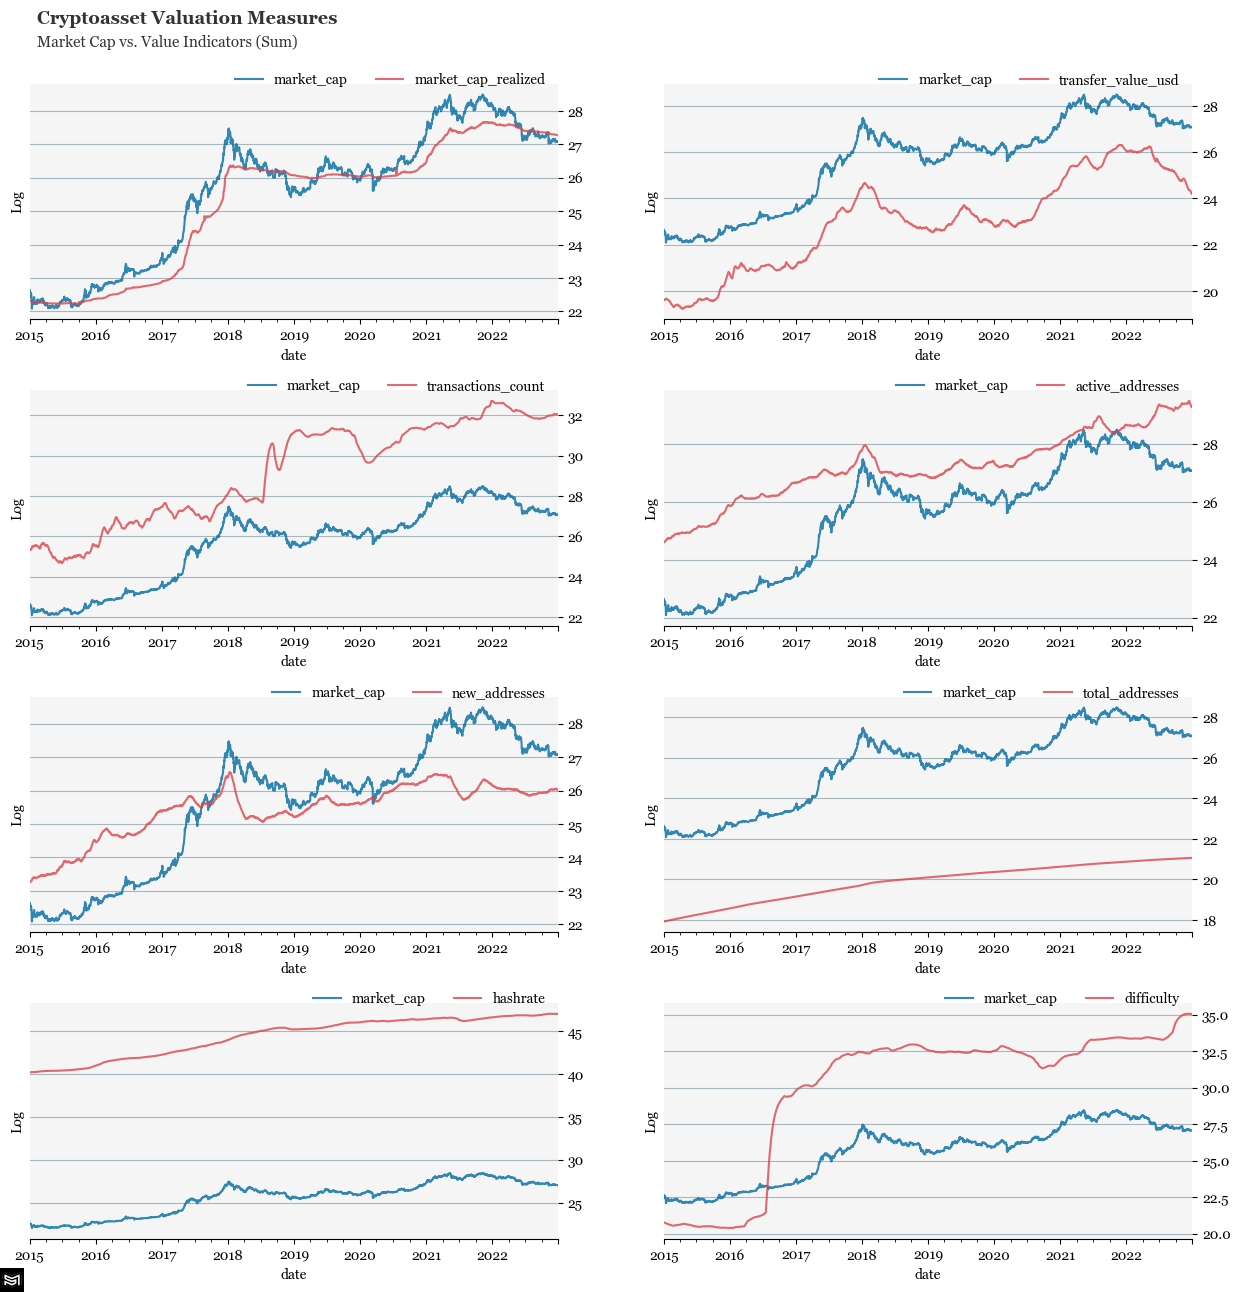

In [59]:
# line plot in Systamental style
# plot size
fig, axes = plt.subplots(figsize=(15, 15), nrows=4, ncols=2)
ax_subplots = ((0,0), (0,1), (1,0), (1,1), (2,0), (2,1), (3,0), (3,1))

# font
plt.rcParams['font.family'] = 'georgia'
# color
colors = ['#006BA2', '#DB444B', '#3EBCD2', '#379A8B', '#EBB434', '#B4BA39', '#9A607F', '#D1B07C', '#758D99']

# plot
for col, axis in zip(plot_df.columns[1:], ax_subplots):
    plot_df.loc['2015-01-01':, ['market_cap', col]].dropna().plot(color=colors, alpha=0.8, ax=axes[axis])
    # grid
    axes[axis].set_axisbelow(True)
    axes[axis].grid(which="major", axis='y', color='#758D99', alpha=0.6)
    axes[axis].set_facecolor("whitesmoke")
    # adjust subplots height space
    plt.subplots_adjust(hspace=0.3)
    #legend   
    axes[axis].legend(bbox_to_anchor=(1, 1.1), loc="upper right", frameon=False, ncol=2)
    # remove splines
    axes[axis].spines[['top', 'right', 'left']].set_visible(False)
    # Reformat y-axis tick labels
    axes[axis].set_ylabel('Log')
    axes[axis].yaxis.tick_right()

# add systamental logo
with resources.path("factorlab", "systamental_logo.png") as f:
    img_path = f
img = Image.open(img_path)
plt.figimage(img, origin='upper')


# Add in title and subtitle
axes[0,0].text(x=0.13, y=.92, s="Cryptoasset Valuation Measures", transform=fig.transFigure, ha='left', fontsize=13,
        weight='bold', alpha=.8, fontdict=None)
axes[0,0].text(x=0.13, y=.905, s="Market Cap vs. Value Indicators (Sum)", transform=fig.transFigure, ha='left', fontsize=11,
        alpha=.8, fontdict=None);


# Feature and Target Variables

## Target Variables

We will need to compute spot, total and forward returns which will be our target variable.

We also compute the equal-weighted and market cap weighted market return to estimate betas/alphas.

In [60]:
# total returns
ret_df = Transform(df.close).returns().rename(columns={'close':'ret'})
ret_df['funding_rate'] = df.funding_rate.fillna(0)
ret_df['tr'] = ret_df.ret - ret_df.funding_rate

In [61]:
# fwd rets
fwd_spot_ret = Transform(df.close).returns(lags=1, forward=True).close.to_frame('fwd_ret_1')
fwd_spot_ret['fwd_ret_5'] = Transform(df.close).returns(lags=5, forward=True)
fwd_spot_ret['fwd_ret_7'] = Transform(df.close).returns(lags=7, forward=True)
fwd_spot_ret['fwd_ret_10'] = Transform(df.close).returns(lags=10, forward=True)
fwd_spot_ret['fwd_ret_14'] = Transform(df.close).returns(lags=14, forward=True)
fwd_spot_ret['fwd_ret_20'] = Transform(df.close).returns(lags=20, forward=True)
fwd_spot_ret['fwd_ret_30'] = Transform(df.close).returns(lags=30, forward=True)
fwd_spot_ret['fwd_ret_60'] = Transform(df.close).returns(lags=60, forward=True)
fwd_spot_ret['fwd_ret_90'] = Transform(df.close).returns(lags=90, forward=True)
fwd_spot_ret['fwd_ret_180'] = Transform(df.close).returns(lags=180, forward=True)
fwd_spot_ret['fwd_ret_365'] = Transform(df.close).returns(lags=365, forward=True)

In [62]:
# total fwd rets
fwd_ret = ret_df.tr.groupby('ticker').shift(-1).fillna(0).to_frame('fwd_ret')
# normalized fwd ret
fwd_ret_norm = Transform(fwd_ret).normalize_ts(window_type='expanding')

In [63]:
# normalized fwd spot rets
fwd_spot_ret_z = Transform(fwd_spot_ret).normalize_ts(window_type='expanding')

In [64]:
# relative returns for cross-section 
fwd_rel_ret = fwd_spot_ret.copy()
for col in fwd_rel_ret.columns:
    fwd_rel_ret[col] = fwd_spot_ret[col] - fwd_spot_ret[col].groupby('date').mean()

In [65]:
# normalize relative returns
fwd_rel_ret_z = Transform(fwd_rel_ret).normalize_ts(window_type='expanding')

In [66]:
# create market cap weights and returns
mkt_df = pd.concat([df, mktcap_df], axis=1)
mkt_df['mkt_cap_weights'] = mkt_df.mkt_cap / mkt_df.mkt_cap.groupby('date').sum()
mkt_df['ret'] = Transform(mkt_df.close).returns()

In [67]:
# create ew and mw market returns
mkt_ret_ew = mkt_df.ret.groupby('date').mean().to_frame('mkt_ret')
mkt_ret_mw = (mkt_df.mkt_cap_weights * mkt_df.ret).groupby('date').sum().to_frame('mkt_ret')

In [68]:
# mkt autocorrelations
mkt_ret_mw.mkt_ret.autocorr()

-0.0965125822552799

In [69]:
mkt_ret_ew.mkt_ret.autocorr()

-0.08242550544737562

## Value Factors

We compute all value factors referenced in any of the literature in order to compare their statistical and predictive properties. All value factors are normalized (z-score) using an expanding window over the time series to account for differences across blockchains (e.g. some blockchains may have significantly higher network activity than others which makes ratio comparisons across assets difficult and potentially meaningless). 

Our value factor horserace will include the following value factors:

1. **Network value to transactions (NVT)**: the network value to transactions ratio is similar to the PE ratio in equity markets. It measures the  value being transmitted on-chain, i.e. the value of the activity on the network. A high NVT ratio indicates high network value relative to network activity/volume, whereas a low NVT ratio points to a low network value relative to network activity/volume. Note that NVT is the inverse of token velocity.
2. **Network value to Metcalfe (NVM)**: Metcalfe's law models a network's value as the square of the number of network users. The network value to Metcalfe ratio is the ratio of network value (or market cap) to the value estimated by Metcalfe law. Deviations from estimated value represent over/undervaluation.
3. **Network value to Stocks-to-flow (NVSF)**: the Stocks-to-Flow ratio measures the issuance ratio of a cryptoasset. The scarcer the asset, the more valuable it is as a store of value. Deviations of the network's value relative to the Stocks-to-Flow ratio represent over/undervaluation.
4. **Network value to Cost of production (NVC)**: the cost of production is often estimated using variables like electricity prices, mining efficiency and difficulty, the issuance rate, and other proxies like hashrate and difficulty. Deviations of the network's value relative to the cost of production represent over/undervaluation.
5. **Market value to realized value (MVRV)**: realized value represents the cost basis of supply. Market prices tend to fluctuate around the cost basis. Extreme deviations between market value and realized value reflect periods of extreme unrealized gains/losses for investors.
6. **Negative long-term price momentum (NPM)**: the negative of long-term price momentum is generic value factor often used in the literature for non-cash flow assets (e.g. commodities, FX, etc). It has been shown to generate portfolios that are highly correlated with those formed with fundamental value characteristics. In addition, prices tend to be mean reverting over long-term time frames which makes them a simple benchmark to compare fundamental value factors against.

**FactorLab** has a `Value` class with various methods like `nvt` and `nvm` which facilitates the construction of all of the value measures shown above. 

In [70]:
value_df =  Value(oc_df, log=True, smoothing='ewm', window_size=30, method='ratio').nvt(nv='mkt_cap', trans_val='tfr_val_usd')
value_df['nvt_resid_30'] =  Value(oc_df, log=True, smoothing='ewm', window_size=30, method='lin_reg', window_type='fixed').nvt(nv='mkt_cap', trans_val='tfr_val_usd')
value_df['nvt_ratio_adj30'] =  Value(oc_df, log=True, smoothing='ewm', window_size=30, method='ratio').nvt(nv='mkt_cap', trans_val='tfr_val_usd_adj')
value_df['nvt_resid_adj30'] =  Value(oc_df, log=True, smoothing='ewm', window_size=30, method='lin_reg').nvt(nv='mkt_cap', trans_val='tfr_val_usd_adj')
value_df['nvt_ratio_cnt30'] =  Value(oc_df, log=True, smoothing='ewm', window_size=30, method='ratio').nvt(nv='mkt_cap', trans_val='tx_count')
value_df['nvt_resid_cnt30'] =  Value(oc_df, log=True, smoothing='ewm', window_size=30, method='lin_reg').nvt(nv='mkt_cap', trans_val='tx_count')
value_df['nvm_ratio_aa30'] =  Value(oc_df, log=True, smoothing='ewm', window_size=30, method='ratio').nvm(nv='mkt_cap', act_users='add_act')
value_df['nvm_ratio_an30'] =  Value(oc_df, log=True, smoothing='ewm', window_size=30, method='ratio').nvm(nv='mkt_cap', act_users='add_new')
value_df['nvm_resid_aa30'] =  Value(oc_df, log=True, smoothing='ewm', window_size=30, method='lin_reg').nvm(nv='mkt_cap', act_users='add_act')
value_df['nvm_resid_an30'] =  Value(oc_df, log=True, smoothing='ewm ', window_size=30, method='lin_reg').nvm(nv='mkt_cap', act_users='add_new')
value_df['nvm_ratio_at30'] =  Value(oc_df, log=True, smoothing='ewm', window_size=30, method='ratio').nvm(nv='mkt_cap', act_users='add_tot')
value_df['nvm_resid_at30'] =  Value(oc_df, log=True, smoothing='ewm', window_size=30, method='lin_reg').nvm(nv='mkt_cap', act_users='add_tot')
value_df['mvrv'] = oc_df.mvrv * -1
value_df['nvsf_resid_30'] = Value(oc_df, method='lin_reg', window_size=30).nvsf()
value_df['nvc_ratio_hash30'] = Value(oc_df, smoothing='ewm ', window_size=30, method='ratio').nvc(nv='mkt_cap', cost='hashrate')
value_df['nvc_resid_hash30'] = Value(oc_df, smoothing='ewm ', window_size=30, method='lin_reg').nvc(nv='mkt_cap', cost='hashrate')
value_df['nvc_ratio_diff30'] = Value(oc_df, smoothing='ewm ', window_size=30, method='ratio').nvc(nv='mkt_cap', cost='diff_mean')
value_df['nvc_resid_diff30'] = Value(oc_df, smoothing='ewm ', window_size=30, method='lin_reg').nvc(nv='mkt_cap', cost='diff_mean')
value_df['npm_365'] = Transform(oc_df.mkt_cap).returns(lags=365).mkt_cap * -1

In [71]:
value_z_df = Transform(value_df).normalize_ts(window_type='expanding')

### Value factor correlations

In [72]:
value_z_df.corr()

mvrv   npm_365  nvc_ratio_diff30  nvc_ratio_hash30  \
mvrv              1.000000  0.583487          0.193439          0.103448   
npm_365           0.583487  1.000000          0.222594          0.160839   
nvc_ratio_diff30  0.193439  0.222594          1.000000          0.507668   
nvc_ratio_hash30  0.103448  0.160839          0.507668          1.000000   
nvc_resid_diff30  0.676164  0.692703          0.585669          0.299587   
nvc_resid_hash30  0.687185  0.668209          0.589405          0.418586   
nvm_ratio_aa30   -0.002650 -0.159901          0.049681         -0.153733   
nvm_ratio_an30   -0.252151 -0.362292               NaN         -0.089558   
nvm_ratio_at30    0.635072  0.527152               NaN          0.302278   
nvm_resid_aa30    0.517961  0.469865          0.281625          0.192636   
nvm_resid_an30    0.528182  0.436519               NaN          0.494114   
nvm_resid_at30    0.733302  0.779673               NaN          0.602302   
nvsf_resid_30     0.603894  0.706944          0.288515          0.112290   
nvt_ratio_30     -0.199092 -0.332655          0.038717         -0.169176   
nvt_ratio_adj30  -0.145367 -0.182429          0.061221         -0.141691   
nvt_ratio_cnt30   0.111024  0.094430          0.224633         -0.167932   
nvt_resid_30      0.212941  0.050465          0.215434         -0.096268   
nvt_resid_adj30   0.406029  0.410039          0.334445          0.170790   
nvt_resid_cnt30   0.491297  0.549762          0.372553          0.221454   

                  nvc_resid_diff30  nvc_resid_hash30  nvm_ratio_aa30  \
mvrv                      0.676164          0.687185       -0.002650   
npm_365                   0.692703          0.668209       -0.159901   
nvc_ratio_diff30          0.585669          0.589405        0.049681   
nvc_ratio_hash30          0.299587          0.418586       -0.153733   
nvc_resid_diff30          1.000000          0.995674        0.439831   
nvc_resid_hash30          0.995674          1.000000        0.372578   
nvm_ratio_aa30            0.439831          0.372578        1.000000   
nvm_ratio_an30                 NaN          0.194551        0.918488   
nvm_ratio_at30                 NaN          0.525803       -0.016356   
nvm_resid_aa30            0.685628          0.638381        0.326267   
nvm_resid_an30                 NaN          0.585383        0.224065   
nvm_resid_at30                 NaN          0.833211       -0.181195   
nvsf_resid_30             0.695891          0.623853       -0.145007   
nvt_ratio_30             -0.074115         -0.094662        0.516944   
nvt_ratio_adj30          -0.059815         -0.080138        0.241101   
nvt_ratio_cnt30           0.453305          0.359088        0.570290   
nvt_resid_30              0.084211          0.073799        0.296247   
nvt_resid_adj30           0.496111          0.405244        0.176086   
nvt_resid_cnt30           0.768556          0.683663        0.338513   

                  nvm_ratio_an30  nvm_ratio_at30  nvm_resid_aa30  \
mvrv                   -0.252151        0.635072        0.517961   
npm_365                -0.362292        0.527152        0.469865   
nvc_ratio_diff30             NaN             NaN        0.281625   
nvc_ratio_hash30       -0.089558        0.302278        0.192636   
nvc_resid_diff30             NaN             NaN        0.685628   
nvc_resid_hash30        0.194551        0.525803        0.638381   
nvm_ratio_aa30          0.918488       -0.016356        0.326267   
nvm_ratio_an30          1.000000       -0.160888        0.010829   
nvm_ratio_at30         -0.160888        1.000000        0.534873   
nvm_resid_aa30          0.010829        0.534873        1.000000   
nvm_resid_an30          0.087354        0.513203        0.942542   
nvm_resid_at30         -0.300652        0.675302        0.658350   
nvsf_resid_30          -0.408459        0.559740        0.593374   
nvt_ratio_30            0.634145       -0.203845       -0.089530   
nvt_ratio_adj30         0.221524       -

# Statistical Analysis

In our statistical analysis, we'll explore the relationship between our value measures and price/forward returns.

This will include:

1. *Stationarity tests*
2. *Granger Causality tests*
2. *Screening methods*
4. *Regression Analysis*


### Stationarity Tests

Stationarity tests allow us to assess the strength of convergence/mean reversion of the time series. This is especially important for a value strategy which is an implicit bet on prices mean reverting to estimated fundamental values.

To assess the stationarity and mean-reversion properties of our value factors, we run both an ADF test and compute the Hurst exponents.

#### Augmented Dickey-Fuller (ADF) Test

The ADF test looks for the presence of a unit root in an autoregressive time series sample. 

https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test

Since our data set includes over 100 assets, rather than testing stationarity for each one, we compute the aggregate sum for each metric (e.g. total market cap, total realized market cap, transfer value in usd, active addresses, etc) and a run a regression (log) to estimate the residuals for each value measure.

Alternatively, one can run each stationarity test individually and average the results. The results should be robust to either approach.

We use `linear_reg` function in **FactorLab** to run the regressions for the ADF tests.

In [73]:
oc_agg_df = oc_df.groupby('date').sum()

In [74]:
resid = linear_reg(oc_agg_df.mkt_cap, oc_agg_df.mkt_cap_real, window_type='expanding', output='resid', log=True,
                                   trend='c').resid.to_frame('mkt_cap_real')
resid['tfr_val_usd'] = linear_reg(oc_agg_df.mkt_cap, oc_agg_df.tfr_val_usd, window_type='expanding', output='resid', log=True,
                                   trend='c')
resid['tfr_val_mean_usd'] = linear_reg(oc_agg_df.mkt_cap, oc_agg_df.tfr_val_mean_usd, window_type='expanding', output='resid', log=True,
                                   trend='c')
resid['tfr_val_usd_adj'] = linear_reg(oc_agg_df.mkt_cap, oc_agg_df.tfr_val_usd_adj, window_type='expanding', output='resid', log=True,
                                   trend='c')
resid['tx_count'] = linear_reg(oc_agg_df.mkt_cap, oc_agg_df.tx_count, window_type='expanding', output='resid', log=True,
                                   trend='c')
resid['add_act'] = linear_reg(oc_agg_df.mkt_cap, oc_agg_df.add_act, window_type='expanding', output='resid', log=True,
                                   trend='c')
resid['add_new'] = linear_reg(oc_agg_df.mkt_cap, oc_agg_df.add_new, window_type='expanding', output='resid', log=True,
                                   trend='c')
resid['add_tot'] = linear_reg(oc_agg_df.mkt_cap, oc_agg_df.add_tot, window_type='expanding', output='resid', log=True,
                                   trend='c')
resid['hashrate'] = linear_reg(oc_agg_df.mkt_cap, oc_agg_df.hashrate, window_type='expanding', output='resid', log=True,
                                   trend='c')
resid['diff_mean'] = linear_reg(oc_agg_df.mkt_cap, oc_agg_df.diff_mean, window_type='expanding', output='resid', log=True,
                                   trend='c')

In [75]:
adf(resid)

adf   p-val  lags  nobs      1%      5%     10%
tfr_val_mean_usd -5.0318  0.0000    28  4521 -3.4318 -2.8622 -2.5671
tfr_val_usd_adj  -4.1446  0.0008    32  4517 -3.4318 -2.8622 -2.5671
tfr_val_usd      -3.6911  0.0042    28  4521 -3.4318 -2.8622 -2.5671
tx_count         -3.6193  0.0054    29  4520 -3.4318 -2.8622 -2.5671
mkt_cap_real     -3.2561  0.0170     8  4541 -3.4318 -2.8622 -2.5671
diff_mean        -3.1994  0.0200    20  4529 -3.4318 -2.8622 -2.5671
add_act          -2.7992  0.0584    30  4519 -3.4318 -2.8622 -2.5671
add_tot          -2.6915  0.0755    23  4526 -3.4318 -2.8622 -2.5671
add_new          -2.3276  0.1632    30  4519 -3.4318 -2.8622 -2.5671
hashrate         -1.9751  0.2976     6  4543 -3.4318 -2.8622 -2.5671

In [76]:
publish_table(adf(resid), title='Augmented Dickey-Fuller Tests', width=760, reset_index=True, decimals=2)

#### Hurst Exponent

The goal of the Hurst Exponent is to provide us with a scalar value that will help us to identify (within the limits of statistical estimation) whether a series it mean reverting, random walking or trending.

The idea behind the Hurst Exponent calculation is that we can use the variance of a log price series to assess the rate of diffusive behaviour. For an arbitrary time lag $\tau$, the variance of $\tau$ is given by:

Var($\tau$) = <|log(t + $\tau$) - log(t)|<sup>2</sup>> ~ $\tau$<sup>2</sup>

- H < 0.5 - The time series is mean reverting
- H = 0.5 - The time series is a Geometric Brownian Motion
- H > 0.5 - The time series is trending

A value of H near 0 is highly mean reverting series whereas a H near 1 indicates a strongly trending series.

https://en.wikipedia.org/wiki/Hurst_exponent

The `hurst` function in **FactorLab** computes Hurst exponents for us. We use the default 365 day lookback window.

In [77]:
hurst(resid, window_size=365)

hurst
tfr_val_usd_adj   0.153359
tfr_val_mean_usd  0.170562
tfr_val_usd       0.181551
add_new           0.336095
add_act           0.346697
tx_count          0.379293
mkt_cap_real      0.424265
hashrate          0.503173
add_tot           0.522374
diff_mean         0.523988

In [78]:
publish_table(hurst(resid, window_size=365), title='Hurst Exponents', reset_index=True, decimals=4)

### Granger Causality Tests

Granger causality tests are often used to assess whether a time series is useful for predicting another. We can use this tests to determine the relationship between features and target, and rank features based on the test statistic (sum of squared residuals F-test).

The `granger_causality` function in **FactorLab** runs granger causality tests and outputs an F-test.

In [79]:
gc_test = granger_causality(np.log(oc_agg_df.mkt_cap).diff(), np.log(oc_agg_df).diff())


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=4547, df_num=1
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=0.5653  , p=0.4522  , df_denom=4547, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=4545, df_num=2
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=1.0570  , p=0.3476  , df_denom=4545, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=4543, df_num=3
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=3
parameter F test:         F=0.9519  , p=0.4145  , df_denom=4543, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=-0.0000 , p=1.

ssr based F test:         F=1.5571  , p=0.1687  , df_denom=4534, df_num=5
ssr based chi2 test:   chi2=7.8045  , p=0.1673  , df=5
likelihood ratio test: chi2=7.7978  , p=0.1677  , df=5
parameter F test:         F=1.5571  , p=0.1687  , df_denom=4534, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.6628  , p=0.1259  , df_denom=4531, df_num=6
ssr based chi2 test:   chi2=10.0055 , p=0.1244  , df=6
likelihood ratio test: chi2=9.9945  , p=0.1249  , df=6
parameter F test:         F=1.6628  , p=0.1259  , df_denom=4531, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.5411  , p=0.1485  , df_denom=4528, df_num=7
ssr based chi2 test:   chi2=10.8236 , p=0.1465  , df=7
likelihood ratio test: chi2=10.8107 , p=0.1471  , df=7
parameter F test:         F=1.5411  , p=0.1485  , df_denom=4528, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3381  , p=0.2193  , df_denom=4525, df_num=8
ssr based chi2

likelihood ratio test: chi2=6.6983  , p=0.4610  , df=7
parameter F test:         F=0.9544  , p=0.4630  , df_denom=4528, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.2212  , p=0.2818  , df_denom=4525, df_num=8
ssr based chi2 test:   chi2=9.8066  , p=0.2789  , df=8
likelihood ratio test: chi2=9.7960  , p=0.2796  , df=8
parameter F test:         F=1.2212  , p=0.2818  , df_denom=4525, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.7674 , p=0.0000  , df_denom=4546, df_num=1
ssr based chi2 test:   chi2=18.7798 , p=0.0000  , df=1
likelihood ratio test: chi2=18.7411 , p=0.0000  , df=1
parameter F test:         F=18.7674 , p=0.0000  , df_denom=4546, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9198  , p=0.0004  , df_denom=4543, df_num=2
ssr based chi2 test:   chi2=15.8570 , p=0.0004  , df=2
likelihood ratio test: chi2=15.8295 , p=0.0004  , df=2
parameter F test:         F=7.919

ssr based F test:         F=7.8500  , p=0.0000  , df_denom=4537, df_num=4
ssr based chi2 test:   chi2=31.4624 , p=0.0000  , df=4
likelihood ratio test: chi2=31.3540 , p=0.0000  , df=4
parameter F test:         F=7.8500  , p=0.0000  , df_denom=4537, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=6.1467  , p=0.0000  , df_denom=4534, df_num=5
ssr based chi2 test:   chi2=30.8081 , p=0.0000  , df=5
likelihood ratio test: chi2=30.7042 , p=0.0000  , df=5
parameter F test:         F=6.1467  , p=0.0000  , df_denom=4534, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.1439  , p=0.3339  , df_denom=4531, df_num=6
ssr based chi2 test:   chi2=6.8833  , p=0.3318  , df=6
likelihood ratio test: chi2=6.8781  , p=0.3323  , df=6
parameter F test:         F=1.1439  , p=0.3339  , df_denom=4531, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.1788  , p=0.3112  , df_denom=4528, df_num=7
ssr based chi2

ssr based F test:         F=1.1151  , p=0.3506  , df_denom=4531, df_num=6
ssr based chi2 test:   chi2=6.7096  , p=0.3485  , df=6
likelihood ratio test: chi2=6.7046  , p=0.3490  , df=6
parameter F test:         F=1.1151  , p=0.3506  , df_denom=4531, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.9944  , p=0.4332  , df_denom=4528, df_num=7
ssr based chi2 test:   chi2=6.9836  , p=0.4306  , df=7
likelihood ratio test: chi2=6.9782  , p=0.4312  , df=7
parameter F test:         F=0.9944  , p=0.4332  , df_denom=4528, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.9079  , p=0.5086  , df_denom=4525, df_num=8
ssr based chi2 test:   chi2=7.2904  , p=0.5056  , df=8
likelihood ratio test: chi2=7.2846  , p=0.5063  , df=8
parameter F test:         F=0.9079  , p=0.5086  , df_denom=4525, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2313  , p=0.2672  , df_denom=4546, df_num=1
ssr based chi2

In [80]:
publish_table(granger_causality(np.log(oc_agg_df.mkt_cap).diff(), np.log(oc_agg_df).diff().drop(columns=['add_tot_squared', 'add_new_squared', 'add_act_squared', 
                                                                           'tx_count_squared', 'nvt', 'nvt_adj', 'mkt_cap', 'mvrv',
                                                                          'mkt_cap_ff'])), 
                                                                 title='Granger Causality Tests', reset_index=True, decimals=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6371  , p=0.2008  , df_denom=4546, df_num=1
ssr based chi2 test:   chi2=1.6382  , p=0.2006  , df=1
likelihood ratio test: chi2=1.6379  , p=0.2006  , df=1
parameter F test:         F=1.6371  , p=0.2008  , df_denom=4546, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9084  , p=0.1484  , df_denom=4543, df_num=2
ssr based chi2 test:   chi2=3.8210  , p=0.1480  , df=2
likelihood ratio test: chi2=3.8194  , p=0.1481  , df=2
parameter F test:         F=1.9084  , p=0.1484  , df_denom=4543, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2477  , p=0.2907  , df_denom=4540, df_num=3
ssr based chi2 test:   chi2=3.7490  , p=0.2899  , df=3
likelihood ratio test: chi2=3.7474  , p=0.2901  , df=3
parameter F test:         F=1.2477  , p=0.2907  , df_denom=4540, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=11.0791 , p=0.

ssr based F test:         F=1.8705  , p=0.1127  , df_denom=4537, df_num=4
ssr based chi2 test:   chi2=7.4970  , p=0.1118  , df=4
likelihood ratio test: chi2=7.4908  , p=0.1121  , df=4
parameter F test:         F=1.8705  , p=0.1127  , df_denom=4537, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.6886  , p=0.1337  , df_denom=4534, df_num=5
ssr based chi2 test:   chi2=8.4634  , p=0.1325  , df=5
likelihood ratio test: chi2=8.4555  , p=0.1329  , df=5
parameter F test:         F=1.6886  , p=0.1337  , df_denom=4534, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.2115  , p=0.2969  , df_denom=4531, df_num=6
ssr based chi2 test:   chi2=7.2900  , p=0.2949  , df=6
likelihood ratio test: chi2=7.2841  , p=0.2954  , df=6
parameter F test:         F=1.2115  , p=0.2969  , df_denom=4531, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.0609  , p=0.3861  , df_denom=4528, df_num=7
ssr based chi2

ssr based F test:         F=0.0197  , p=1.0000  , df_denom=4531, df_num=6
ssr based chi2 test:   chi2=0.1184  , p=1.0000  , df=6
likelihood ratio test: chi2=0.1184  , p=1.0000  , df=6
parameter F test:         F=0.0197  , p=1.0000  , df_denom=4531, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.0228  , p=1.0000  , df_denom=4528, df_num=7
ssr based chi2 test:   chi2=0.1602  , p=1.0000  , df=7
likelihood ratio test: chi2=0.1602  , p=1.0000  , df=7
parameter F test:         F=0.0228  , p=1.0000  , df_denom=4528, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.0203  , p=1.0000  , df_denom=4525, df_num=8
ssr based chi2 test:   chi2=0.1631  , p=1.0000  , df=8
likelihood ratio test: chi2=0.1631  , p=1.0000  , df=8
parameter F test:         F=0.0203  , p=1.0000  , df_denom=4525, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1870  , p=0.0743  , df_denom=4546, df_num=1
ssr based chi2

### Filter Methods

Filter-based methods are a category of supervised feature selection technique that are independent from the ML algorithm and can be used to evaluate the relationship between features (value measures) and the target variable (forward returns), and rank the features based on the strength of their statistical relationship with the target.

The `Factor` class has a `filter` method which allows us to run a filter on our value measures and forward returns. Standardized value measures are first discretized into quantiles/bins and ranked by the selected statistical measure. Here we used Spearman correlation.

#### Time series

In [81]:
# compute stats for time series strategies
stats_ts_1d_df = Factor(value_z_df, fwd_spot_ret_z.fwd_ret_1, strategy='ts_ls', factor_bins=3, target_bins=3).filter(metrics=['spearman_r', 'p-val', 'cramer_v', 'chi2', 'mutual_info', 'autocorrelation'], rank_on='spearman_r')

In [82]:
publish_table(stats_ts_1d_df, title='Filter - Value Factors vs. 1 Day Forward returns (TS)', width=800, col_width=[200,150], reset_index=True)

In [83]:
# compute stats for time series strategies
stats_ts_7d_df = Factor(value_z_df, fwd_spot_ret_z.fwd_ret_7, strategy='ts_ls', factor_bins=3, target_bins=3).filter(metrics=['spearman_r', 'p-val', 'cramer_v', 'chi2', 'mutual_info', 'autocorrelation'], rank_on='spearman_r')

In [84]:
publish_table(stats_ts_7d_df, title='Filter - Value Factors vs. 7 Day Forward returns (TS)', width=800, col_width=[200,150], reset_index=True)

In [85]:
# compute stats for time series strategies
stats_ts_30d_df = Factor(value_z_df, fwd_spot_ret_z.fwd_ret_30, strategy='ts_ls', factor_bins=3, target_bins=3).filter(metrics=['spearman_r', 'p-val', 'cramer_v', 'chi2', 'mutual_info', 'autocorrelation'], rank_on='spearman_r')

In [86]:
publish_table(stats_ts_30d_df, title='Filter - Value Factors vs. 30 Day Forward returns (TS)', width=800, col_width=[200,150], reset_index=True)

In [87]:
# compute stats for time series strategies
stats_ts_90d_df = Factor(value_z_df, fwd_spot_ret_z.fwd_ret_90, strategy='ts_ls', factor_bins=3, target_bins=3).filter(metrics=['spearman_r', 'p-val', 'cramer_v', 'chi2', 'mutual_info', 'autocorrelation'], rank_on='spearman_r')

In [88]:
publish_table(stats_ts_90d_df, title='Filter - Value Factors vs. 90 Day Forward returns (TS)', width=800, col_width=[200,150], reset_index=True)

#### Cross sectional

In [89]:
# compute stats for cross sectional strategies
stats_cs_1d_df = Factor(value_z_df, fwd_rel_ret_z.fwd_ret_1, strategy='cs_ls', factor_bins=5, target_bins=3).filter(metrics=['spearman_r', 'p-val', 'cramer_v', 'chi2', 'mutual_info', 'autocorrelation'], rank_on='spearman_r')

In [90]:
publish_table(stats_cs_1d_df, title='Filter - Value Factors vs. 1 Day Forward returns (CS)', width=800, col_width=[200,150], reset_index=True)

In [91]:
# compute stats for cross sectional strategies
stats_cs_7d_df = Factor(value_z_df, fwd_rel_ret_z.fwd_ret_7, strategy='cs_ls', factor_bins=5, target_bins=3).filter(metrics=['spearman_r', 'p-val', 'cramer_v', 'chi2', 'mutual_info', 'autocorrelation'], rank_on='spearman_r')

In [92]:
publish_table(stats_cs_7d_df, title='Filter - Value Factors vs. 7 Day Forward returns (CS)', width=800, col_width=[200,150], reset_index=True)

In [93]:
# compute stats for cross sectional strategies
stats_cs_30d_df = Factor(value_z_df, fwd_rel_ret_z.fwd_ret_30, strategy='cs_ls', factor_bins=5, target_bins=3).filter(metrics=['spearman_r', 'p-val', 'cramer_v', 'chi2', 'mutual_info', 'autocorrelation'], rank_on='spearman_r')

In [94]:
publish_table(stats_cs_30d_df, title='Filter - Value Factors vs. 30 Day Forward returns (CS)', width=800, col_width=[200,150], reset_index=True)

In [95]:
# compute stats for cross sectional strategies
stats_cs_90d_df = Factor(value_z_df, fwd_rel_ret_z.fwd_ret_90, strategy='cs_ls', factor_bins=5, target_bins=3).filter(metrics=['spearman_r', 'p-val', 'cramer_v', 'chi2', 'mutual_info', 'autocorrelation'], rank_on='spearman_r')

In [96]:
publish_table(stats_cs_90d_df, title='Filter - Value Factors vs. 90 Day Forward returns (CS)', width=800, col_width=[200,150], reset_index=True)

### Regression Analysis

We can use the **FactorLab** `regression` method in the `Factor` class to run *pooled* and *Fama-Macbeth* regressions in order to assess the economic and statistical significance of our value measures for both time series and cross sectional implementations. Regressions use a robust estimator (Newey-West) to account for heteroskedasticity and autocorrelation.

Value measures are ranked by betas to forward returns. We use 1, 7, 30 and 90 day forward return windows. Both value measures and forward returns are normalized (z-score).

#### Pooled regression

In [97]:
reg_1d_pooled = Factor(value_z_df, fwd_spot_ret_z.fwd_ret_1).regression(method='pooled')

In [98]:
publish_table(reg_1d_pooled.astype(float), title='Pooled Regressions - 1 Day Forward Returns', decimals=4, reset_index=True)

In [99]:
reg_7d_pooled = Factor(value_z_df, fwd_spot_ret_z.fwd_ret_7).regression(method='pooled')

In [100]:
publish_table(reg_7d_pooled.astype(float), title='Pooled Regressions - 7 Day Forward Returns', decimals=4, reset_index=True)

In [101]:
reg_30d_pooled = Factor(value_z_df, fwd_spot_ret_z.fwd_ret_30).regression(method='pooled')

In [102]:
publish_table(reg_30d_pooled.astype(float), title='Pooled Regressions - 30 Day Forward Returns', decimals=4, reset_index=True)

In [103]:
reg_90d_pooled = Factor(value_z_df, fwd_spot_ret_z.fwd_ret_90).regression(method='pooled')

In [104]:
publish_table(reg_90d_pooled.astype(float), title='Pooled Regressions - 90 Day Forward Returns', decimals=4, reset_index=True)

#### Fama Macbeth


In [105]:
fm_1d_reg = Factor(value_z_df, fwd_spot_ret_z.fwd_ret_1).regression(method='fama-macbeth', nobs=3)

In [106]:
publish_table(fm_1d_reg, title='Fama Macbeth Regressions - 1 Day Forward Returns', reset_index=True)

In [107]:
fm_7d_reg = Factor(value_z_df, fwd_spot_ret.fwd_ret_7).regression(method='fama-macbeth', nobs=3)

In [108]:
publish_table(fm_7d_reg, title='Fama Macbeth Regressions - 7 Day Forward Returns', reset_index=True)

In [109]:
fm_30d_reg = Factor(value_z_df, fwd_spot_ret_z.fwd_ret_30).regression(method='fama-macbeth', nobs=3)

In [110]:
publish_table(fm_30d_reg, title='Fama Macbeth Regressions - 30 Day Forward Returns', reset_index=True)

In [111]:
fm_90d_reg = Factor(value_z_df, fwd_spot_ret_z.fwd_ret_90).regression(method='fama-macbeth', nobs=3)

In [112]:
publish_table(fm_90d_reg, title='Fama Macbeth Regressions - 90 Day Forward Returns', reset_index=True)

# Factor Return Analysis

In our factor return analysis, we'll explore the profitability of our value factors for both time series and cross-sectional trading strategies.

Our factor analysis involves computing factor returns by scaling forward returns on value factor signals (forecasts). Note that this analysis is carried out with little or no optimization since the goal is to uncover robust alpha/risk factors, rather than overfitting the data.

We will consider a few key properties of our factor returns:

- **Factor quantiles**: we evaluate forward returns over varying window lengths across factor quantiles. Robust factors-based strategies will typically show a monotonic relationship between factor quantiles and forward returns.
- **Cumulative returns**: cumulative returns, aka the equity curve, give us a good sense of whether the factor-based strategy has merit. A robust and profitable factor will produce returns that go from the lower left to upper right.
- **Performance metrics**: factor returns can be evaluated like any asset or strategy returns, using measures of risk and retun. We are looking for factor that produce high risk-adjusted returns which are distinct from those produced by long exposure to the market (aka alpha). 
- **Parameter grid search**: factor returns can be very sensitive to parameter choices, e.g. window size/lookback in momentum strategies. A parameter grid search allows us to assess how factors performn across a broad range of parameters. We are looking for a parameter grid space which is robust to small changes in parameter values.


## Factor Quantiles

The `Factor` class has a `ret_quantiles` method which allows us to compare average forward returns by factor quantile.

#### Time Series

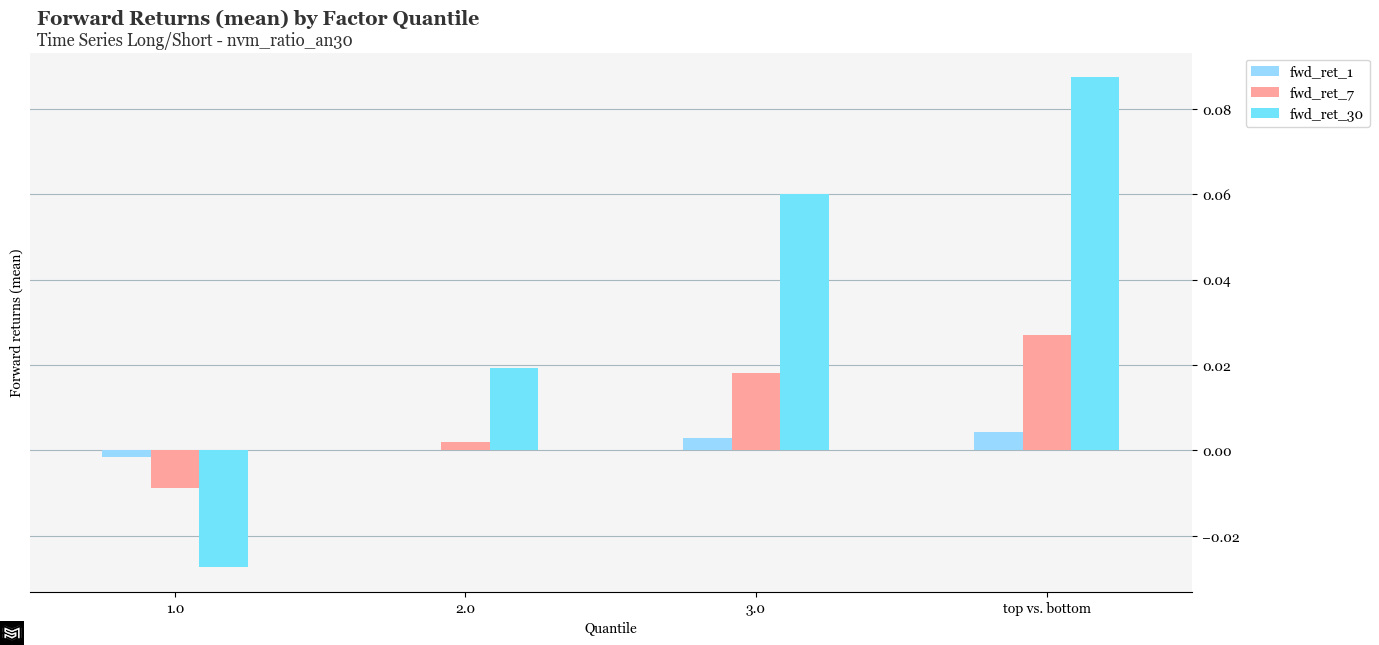

In [113]:
quantile_ts_ret = Factor(value_z_df, fwd_spot_ret[['fwd_ret_1', 'fwd_ret_7', 'fwd_ret_30']], strategy='ts_ls', factor_bins=3).ret_quantiles(factor='nvm_ratio_an30', plot_rets=True)

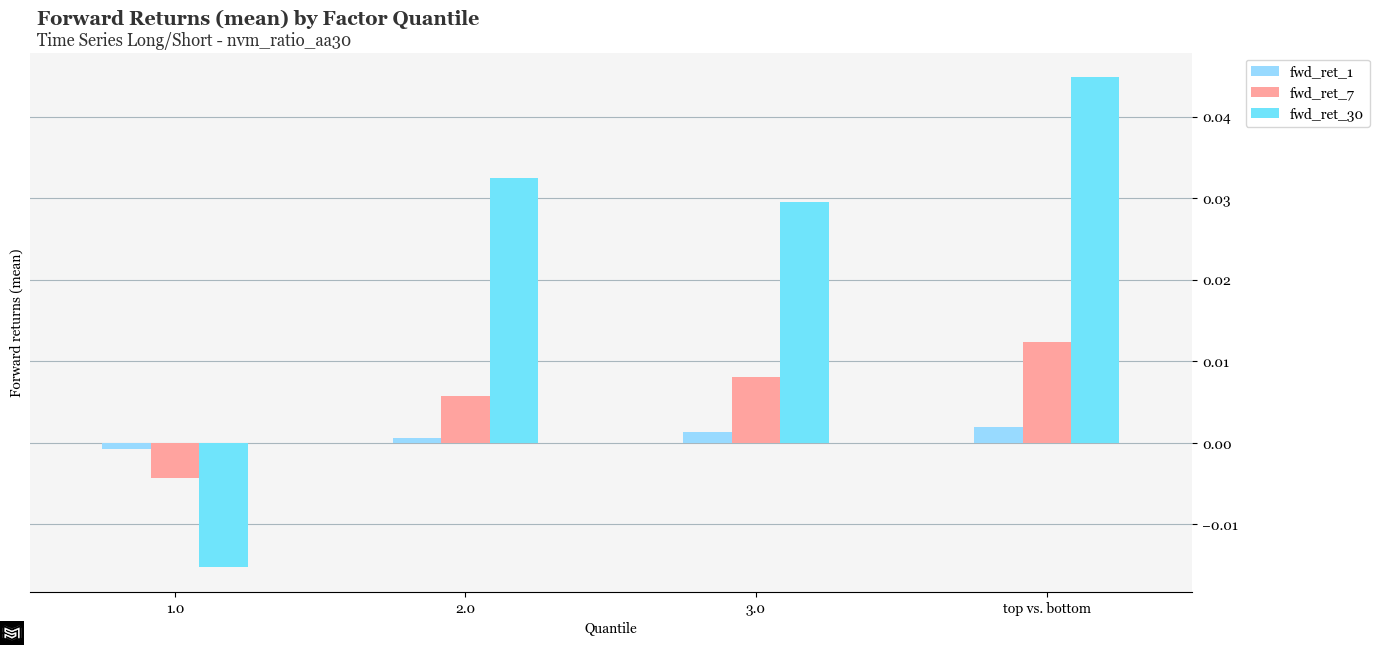

In [114]:
quantile_ts_ret = Factor(value_z_df, fwd_spot_ret[['fwd_ret_1', 'fwd_ret_7', 'fwd_ret_30']], strategy='ts_ls', factor_bins=3).ret_quantiles(factor='nvm_ratio_aa30', plot_rets=True)

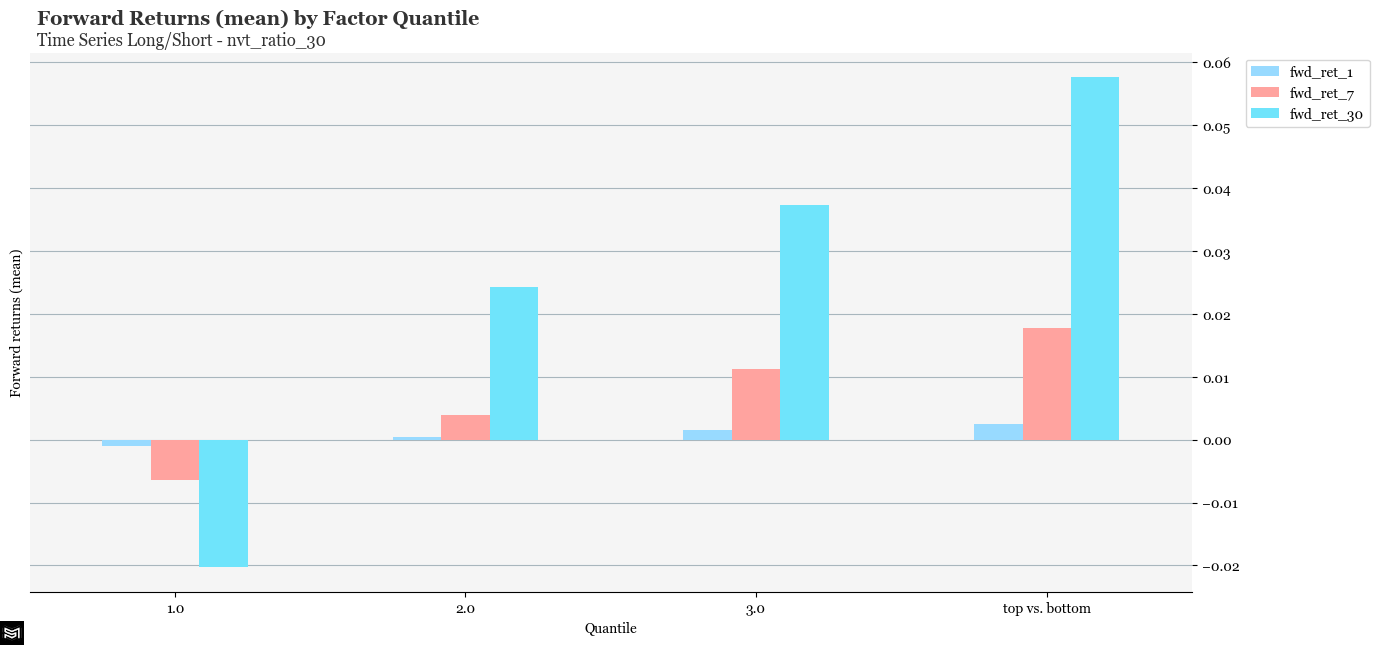

In [115]:
quantile_ts_ret = Factor(value_z_df, fwd_spot_ret[['fwd_ret_1', 'fwd_ret_7', 'fwd_ret_30']], strategy='ts_ls', factor_bins=3).ret_quantiles(factor='nvt_ratio_30', plot_rets=True)

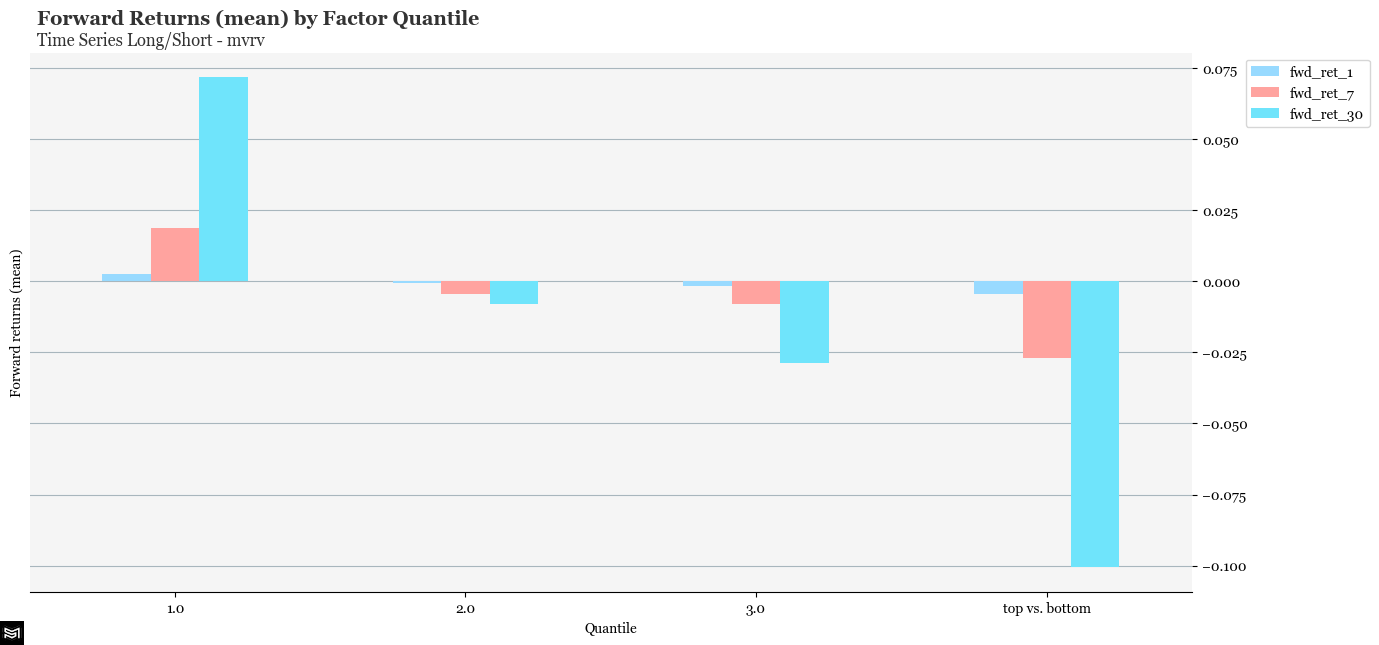

In [116]:
quantile_ts_ret = Factor(value_z_df, fwd_spot_ret[['fwd_ret_1', 'fwd_ret_7', 'fwd_ret_30']], strategy='ts_ls', factor_bins=3).ret_quantiles(factor='mvrv', plot_rets=True)

#### Cross-sectional

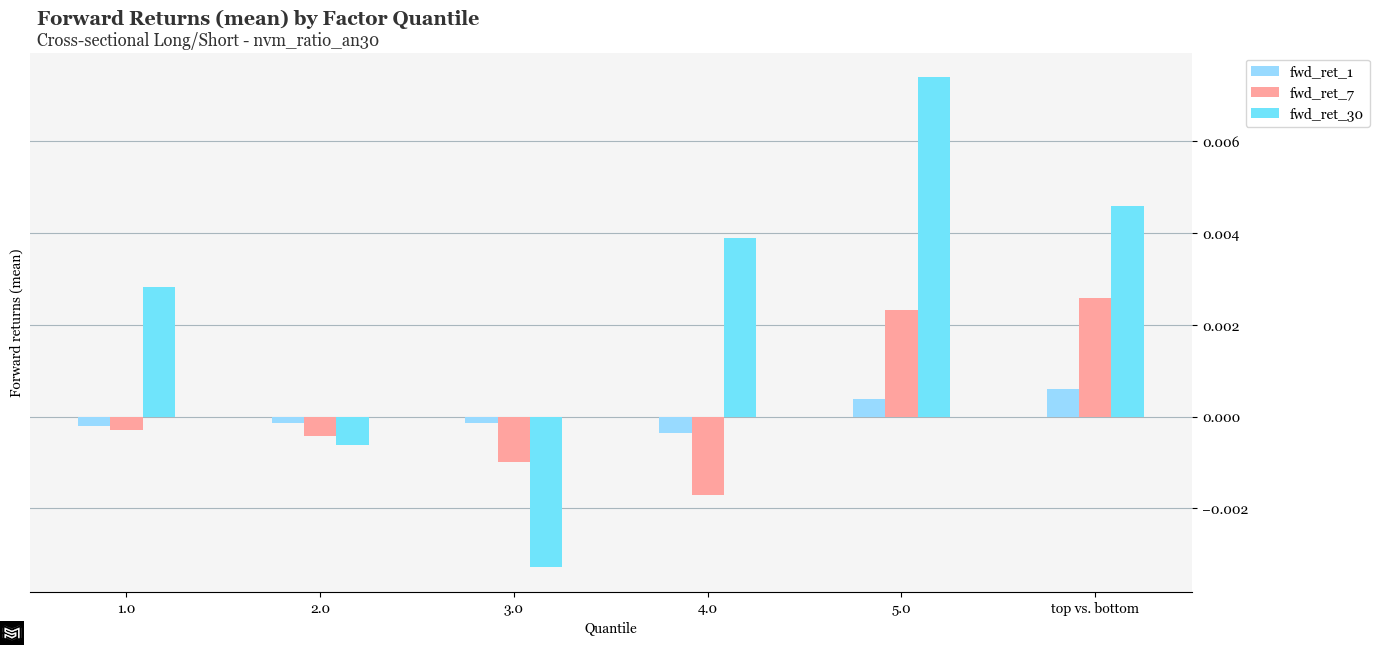

In [117]:
quantile_cs_ret = Factor(value_z_df, fwd_spot_ret[['fwd_ret_1', 'fwd_ret_7', 'fwd_ret_30']], strategy='cs_ls', factor_bins=5).ret_quantiles(factor='nvm_ratio_an30', plot_rets=True)

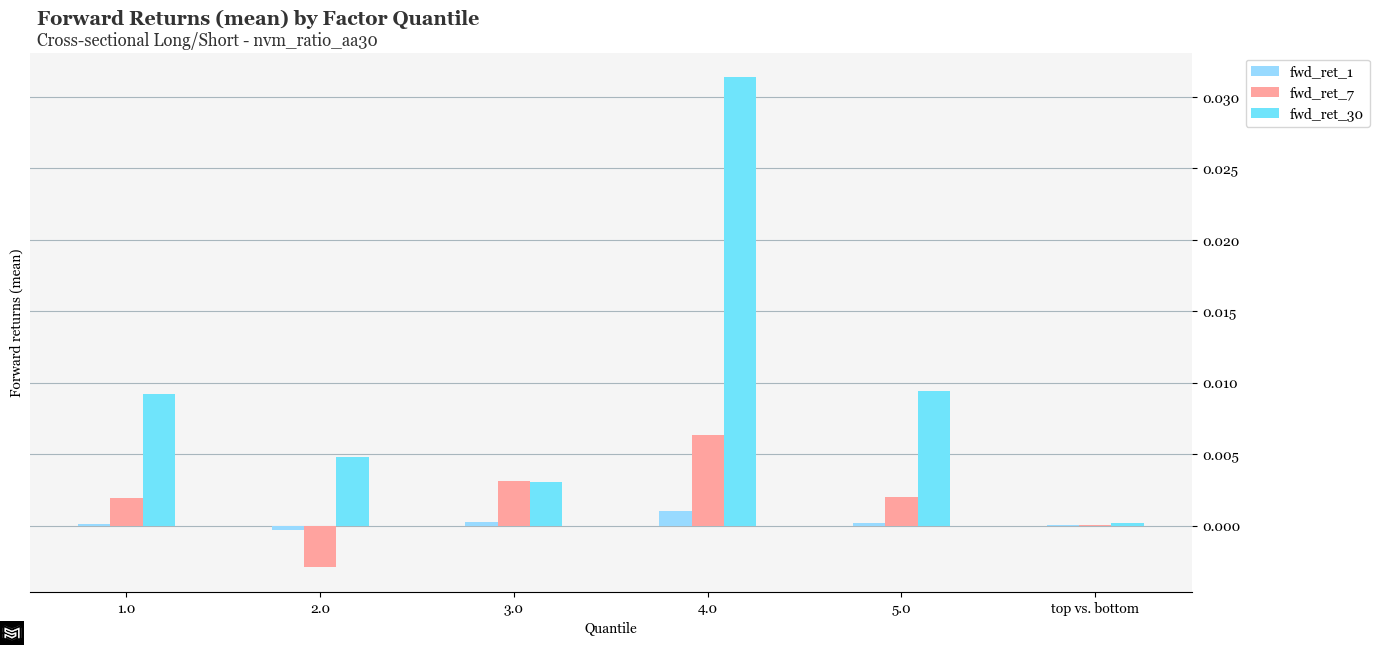

In [118]:
quantile_cs_ret = Factor(value_z_df, fwd_spot_ret[['fwd_ret_1', 'fwd_ret_7', 'fwd_ret_30']], strategy='cs_ls', factor_bins=5).ret_quantiles(factor='nvm_ratio_aa30', plot_rets=True)

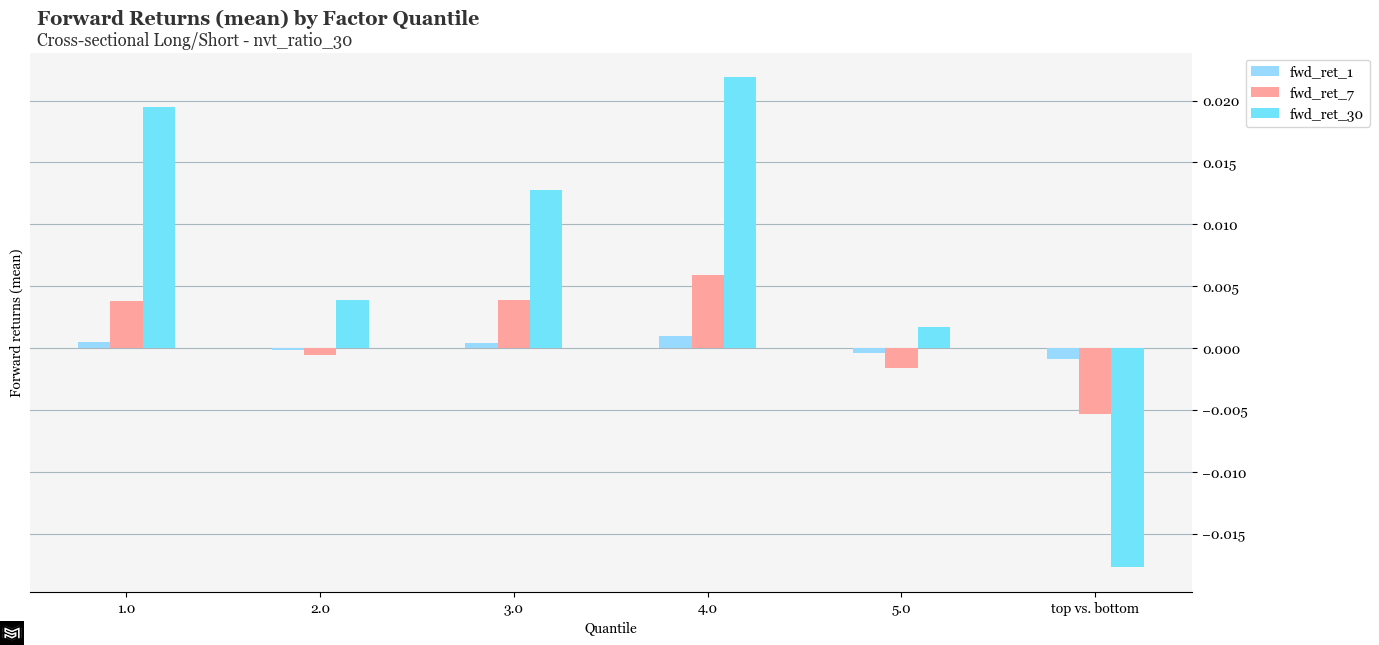

In [119]:
quantile_cs_ret = Factor(value_z_df, fwd_spot_ret[['fwd_ret_1', 'fwd_ret_7', 'fwd_ret_30']], strategy='cs_ls', factor_bins=5).ret_quantiles(factor='nvt_ratio_30', plot_rets=True)

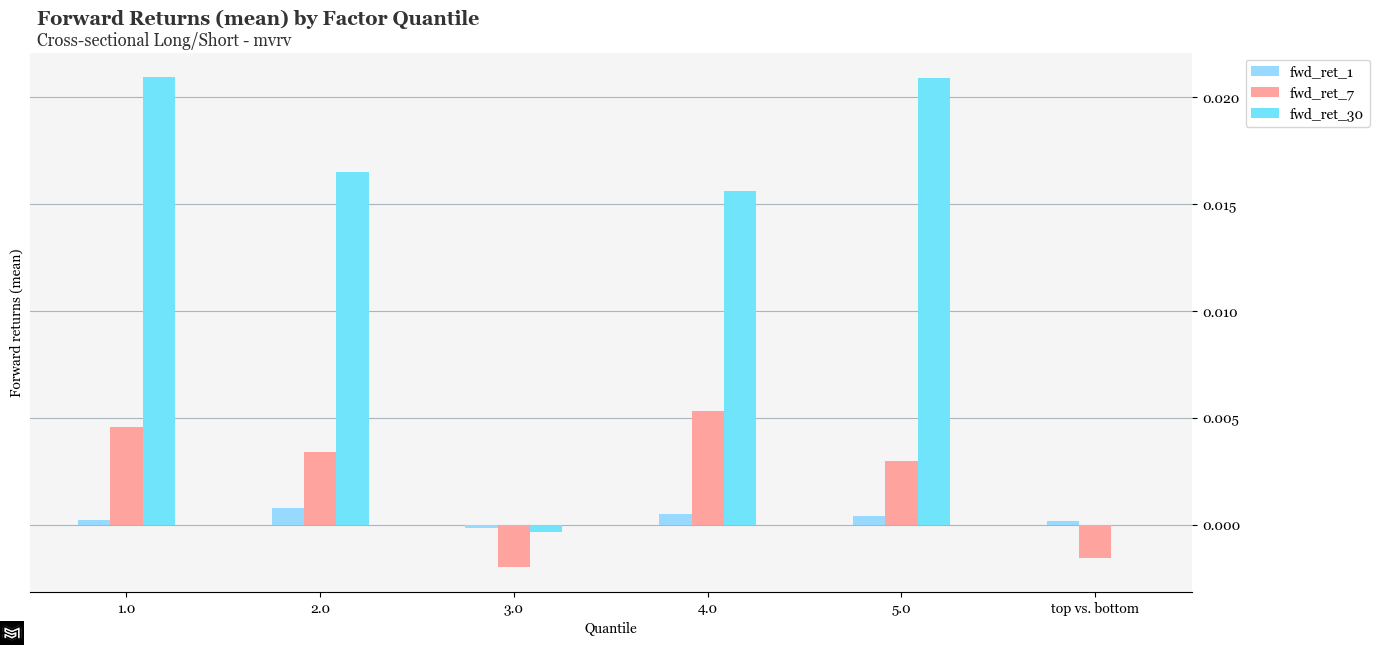

In [120]:
quantile_cs_ret = Factor(value_z_df, fwd_spot_ret[['fwd_ret_1', 'fwd_ret_7', 'fwd_ret_30']], strategy='cs_ls', factor_bins=5).ret_quantiles(factor='mvrv', plot_rets=True)

## Cumulative Returns

#### Time Series Strategy

Time strategies go long assets with high factor values, and short assets with low factor values relative to their past history. Factor values are converted to signals on which one-period ahead forward returns are scaled to obtain factor returns.

Strategy parameters are not optimized and are set to:

- `signal_type`: value factors are converted to continuous signals between 1 and -1.
- `rebalancing`: weekly/7 day portfolio rebalancing
- `t_cost`: 20 bps transaction cost
- `weighting`: signals are adjusted by a volatility scaling factor that targets 10% volatility.

The `Factor` class has a `returns` method which allows us to compute factor returns with specific strategy parameters.

In [121]:
# ts carry returns
value_ts_ret = Factor(value_df, ret_df.tr, strategy='ts_ls', factor_bins=3).returns(signal_type='signal', rebalancing=7, t_cost=0.002, weighting='iv')

The `Performance` class has a `plot_metric` method which plots a time series of any financial performance metric. Here we plot cumulative returns.

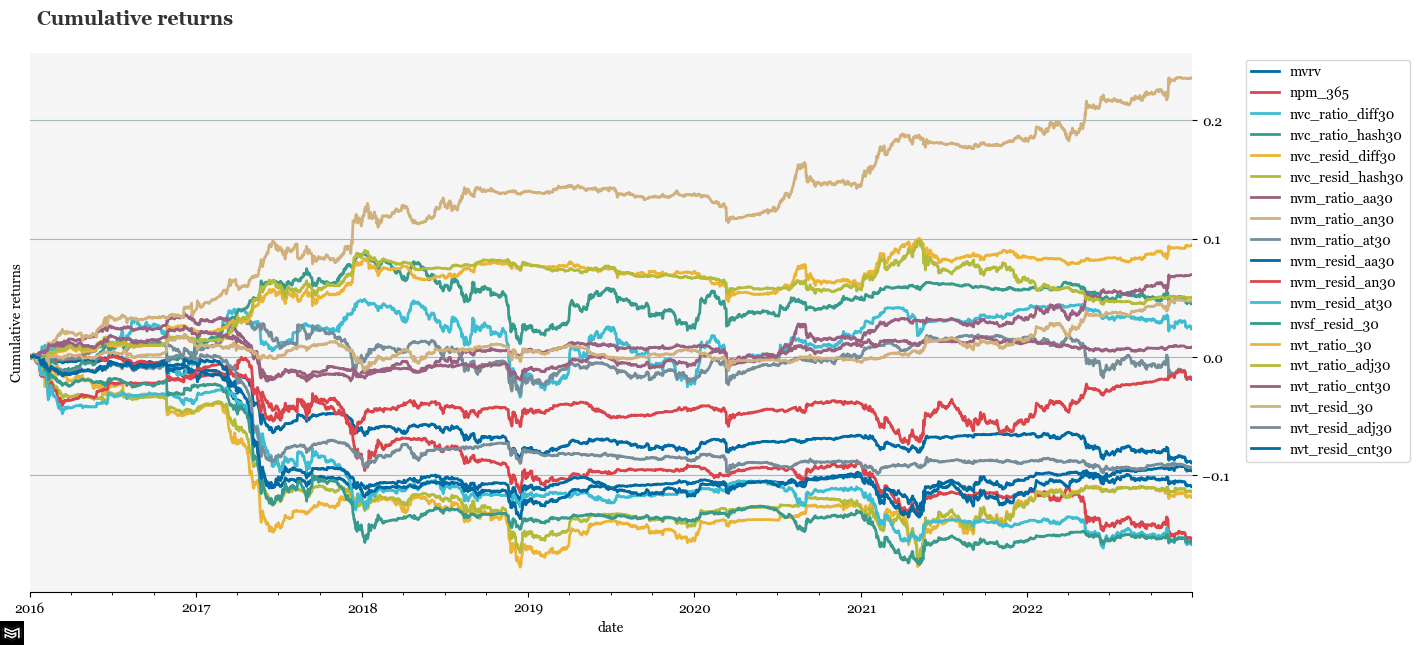

In [122]:
Performance(value_ts_ret.loc['2016-01-01':,:], mkt_ret=mkt_ret_mw, ret_type='log').plot_metric(metric='cumulative_ret')

#### Cross-Sectional Strategy
Cross-sectional strategies sort assets into quantiles based on their factor values. A long portfolio is formed from the top quantile, and a short portfolio from the bottom quantile.

Strategy parameters are not optimized and are set to:
- `quantiles`: 5
- `tails`: two (use only top and bottom quantiles)
- `cs_norm`: normalize value measures over time series before creating quantiles.
- `rebalancing`: weekly/7 day portfolio rebalancing
- `t_cost`: 20 bps transaction cost
- `weighting`: inverse vol (iv)

In [123]:
# cs returns
value_cs_ret = Factor(value_df, ret_df.tr, strategy='cs_ls', factor_bins=5).returns(signal_type='signal_quantiles', cs_norm=True, tails='two', rebalancing=7, t_cost=0.002, weighting='iv')

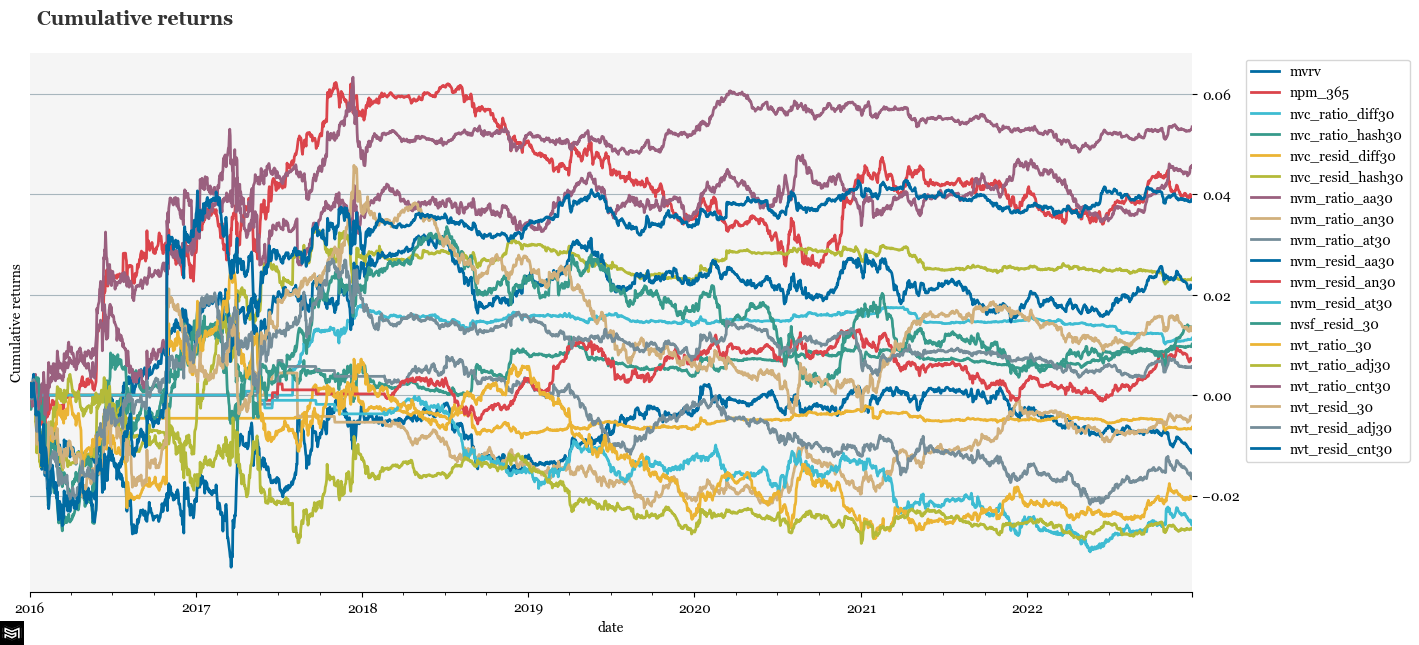

In [124]:
Performance(value_cs_ret.loc['2016-01-01':,:], mkt_ret=mkt_ret_mw, ret_type='log').plot_metric()

## Performance Metrics

The `Performance` class has a `table` method which computes a wide variety of financial performance metrics and ranks them on a specified metric. We use Sharpe ratio below.

In [125]:
perf_ts_table = Performance(value_ts_ret.loc['2016-01-01':,:], mkt_ret=mkt_ret_mw, ret_type='log').table(metrics='key_metrics', rank_on='Sharpe ratio')

In [126]:
publish_table(perf_ts_table, title='Performance - Time Series Value', reset_index=True)

In [127]:
perf_cs_table = Performance(value_cs_ret.loc['2016-01-01':,:], mkt_ret=mkt_ret_mw, ret_type='log').table(metrics='key_metrics', rank_on='Sharpe ratio')

In [128]:
publish_table(perf_cs_table, title='Performance - Cross-sectional Value', reset_index=True)

## Parameter Grid Search

Rather than pick an arbitrary parameter value as most academic studies do, **FactorLab** has a `factor_param_grid_search` function allows us to explore the parameter space.

A robust value factor should be insensitive to changes in inputs and small changes in parameter values. A factor which produces positive returns only across a narrow set of parameter values is more likely to be spurious.

In [129]:
# parameter grid search
nvm_ts_param_df = factor_param_grid_search(oc_df, fwd_ret, Value, 'nvm',
                                           
                         feat_args = {
                             'log': [True, False],
                             'smoothing': ['smw','ewm','median'],
                             'window_size': [3, 5, 7, 14, 21, 30, 60, 90, 120, 180, 365],
                             'method': ['ratio', 'lin_reg']
                                },
                     algo_args = { 'act_users': ['add_new', 'add_act'],
                                  'norm': [True, False],
                                 },
                     factor_args = {'strategy': 'ts_ls'},
                     ret_args = {'signal_type': 'signal', 'rebalancing': 7, 't_cost': 0.002, 'weighting': 'iv'}
                               )

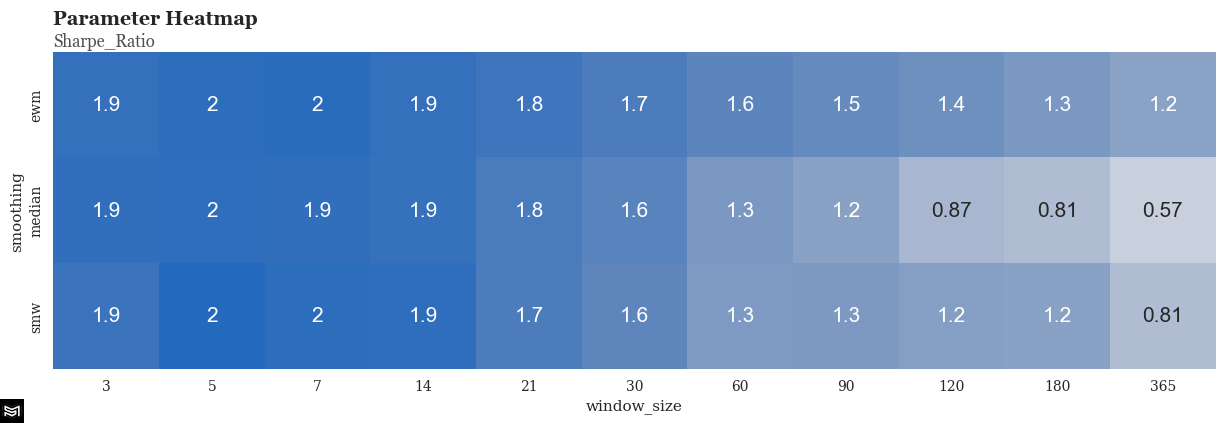

In [130]:
param_heatmap(nvm_ts_param_df, metric='sharpe_ratio', fixed_params={'log': True, 'method': 'ratio', 'act_users': 'add_new', 'norm': True}, plot_params=['smoothing', 'window_size'])

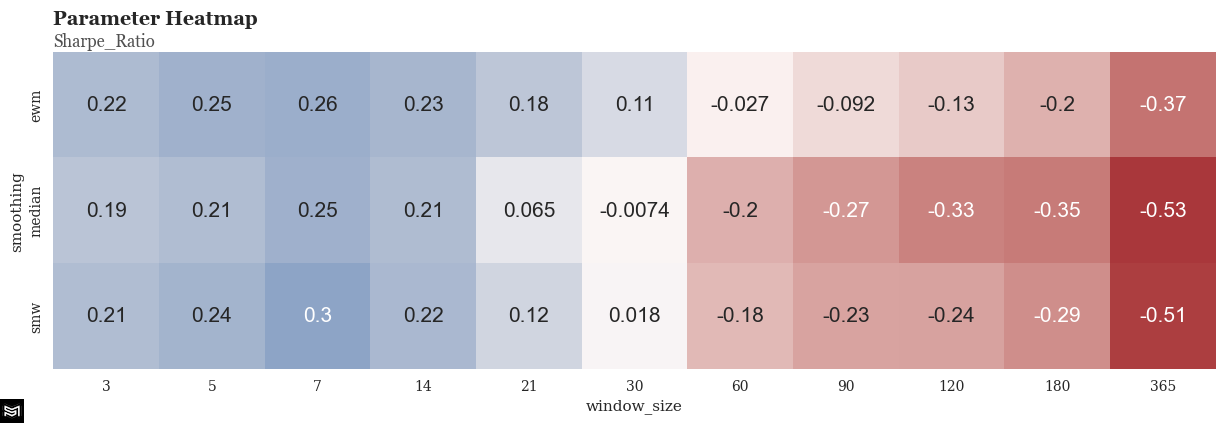

In [131]:
param_heatmap(nvm_ts_param_df, metric='sharpe_ratio', fixed_params={'log': True, 'method': 'lin_reg', 'act_users': 'add_new', 'norm': True}, plot_params=['smoothing', 'window_size'])

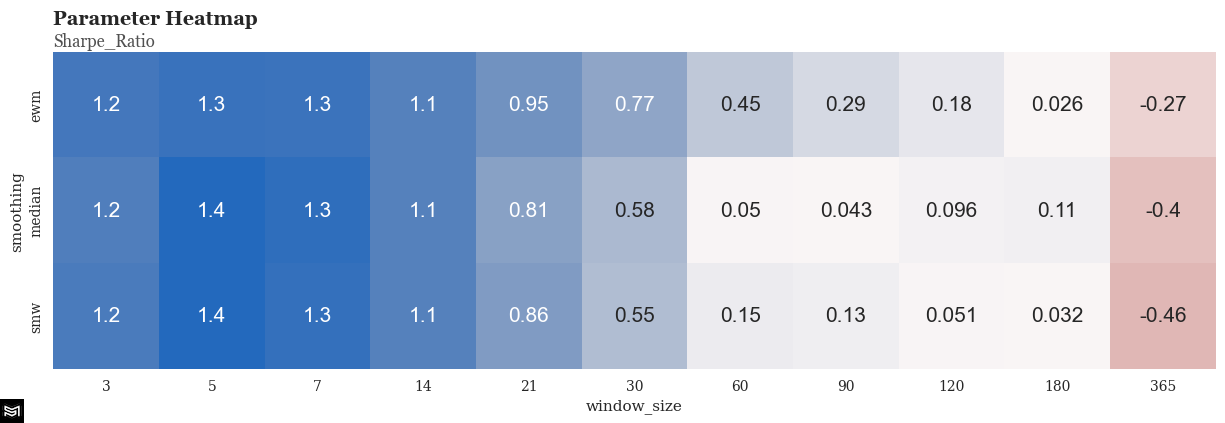

In [135]:
param_heatmap(nvm_ts_param_df, metric='sharpe_ratio', fixed_params={'log': True, 'method': 'ratio', 'act_users': 'add_act', 'norm': True}, plot_params=['smoothing', 'window_size'])

In [148]:
nvm_ts_param_h1_df = factor_param_grid_search(oc_df.loc['2016-01-01':'2019-12-31'], fwd_ret, Value, 'nvm',
                                feat_args = {
                                    'log': [True, False],
                                  'smoothing': ['smw','ewm','median'],
                                   'window_size': [3, 5, 7, 14, 21, 30, 60, 90, 120, 180, 365],
                                    'method': ['ratio', 'lin_reg']
                                },
                     algo_args = { 'act_users': ['add_act', 'add_new'],
                                  'norm': [True, False],
                                 },
                     factor_args = {'strategy': 'ts_ls'},
                     ret_args = {'signal_type': 'signal', 'rebalancing': 7, 't_cost': 0.002, 'weighting': 'iv'}
                               )

In [149]:
nvm_ts_param_h2_df = factor_param_grid_search(oc_df.loc['2020-01-01':], fwd_ret, Value, 'nvm',
                                feat_args = {
                                    'log': [True, False],
                                  'smoothing': ['smw','ewm','median'],
                                   'window_size': [3, 5, 7, 14, 21, 30, 60, 90, 120, 180, 365],
                                    'method': ['ratio', 'lin_reg']
                                },
                     algo_args = { 'act_users': ['add_act', 'add_new'],
                                  'norm': [True, False],
                                 },
                     factor_args = {'strategy': 'ts_ls'},
                     ret_args = {'signal_type': 'signal', 'rebalancing': 7, 't_cost': 0.002, 'weighting': 'iv'}
                               )

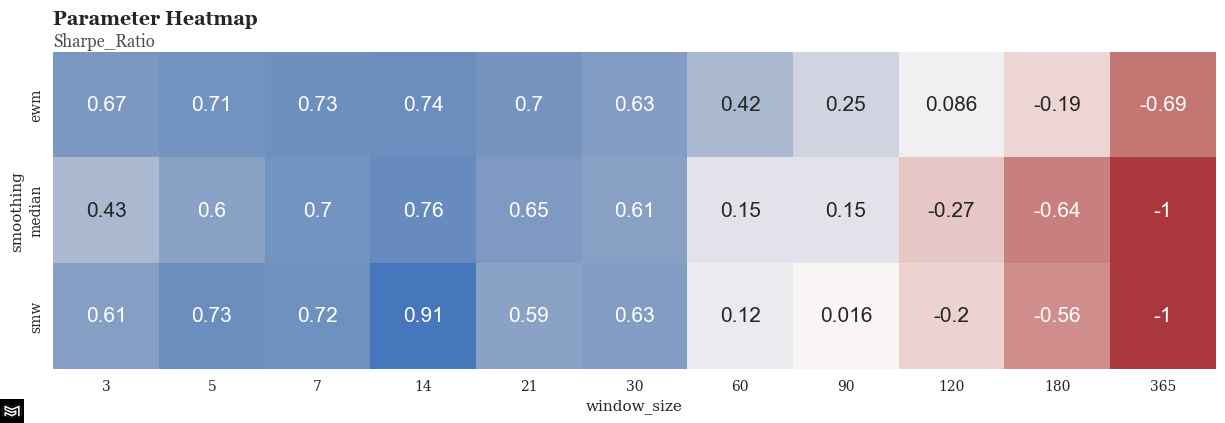

In [150]:
param_heatmap(nvm_ts_param_h1_df, metric='sharpe_ratio', fixed_params={'log': True, 'method': 'ratio', 'act_users': 'add_new', 'norm': True}, plot_params=['smoothing', 'window_size'])

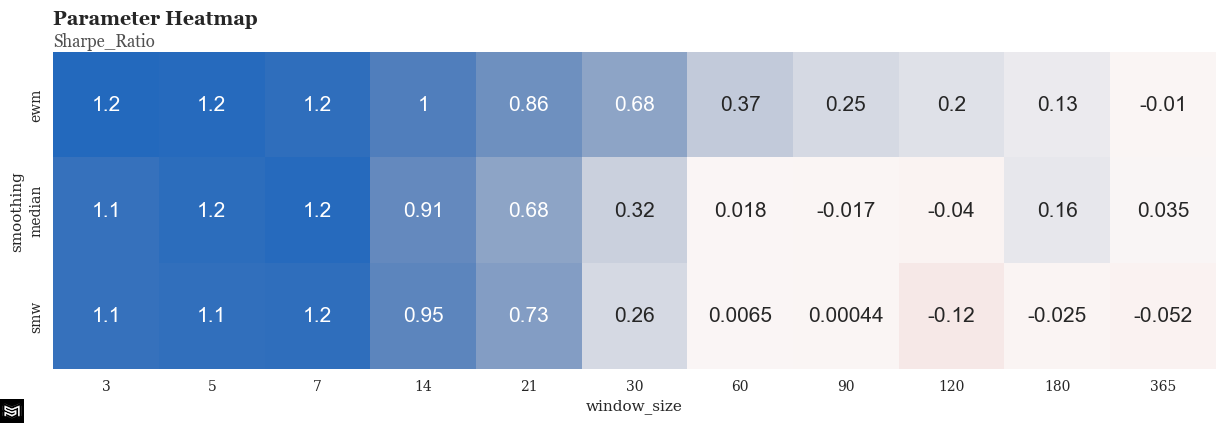

In [151]:
param_heatmap(nvm_ts_param_h2_df, metric='sharpe_ratio', fixed_params={'log': True, 'method': 'ratio', 'act_users': 'add_new', 'norm': True}, plot_params=['smoothing', 'window_size'])

In [152]:
nvm_cs_param_df = factor_param_grid_search(oc_df, fwd_ret, Value, 'nvm',
                                feat_args = {
                                    'log': [True, False],
                                  'smoothing': ['smw','ewm','median'],
                                   'window_size': [3, 5, 7, 14, 21, 30, 60, 90, 120, 180, 365],
                                    'method': ['ratio', 'lin_reg']
                                },
                     algo_args = { 'act_users': ['add_new', 'add_act'],
                                  'norm': [True, False],
                                 },
                     factor_args = {'strategy': 'cs_ls', 'factor_bins':5},
                     ret_args = {'signal_type': 'signal_quantiles', 'tails': 'two', 'cs_norm': True, 'rebalancing': 7, 't_cost': 0.002, 'weighting': 'iv'}
                               )

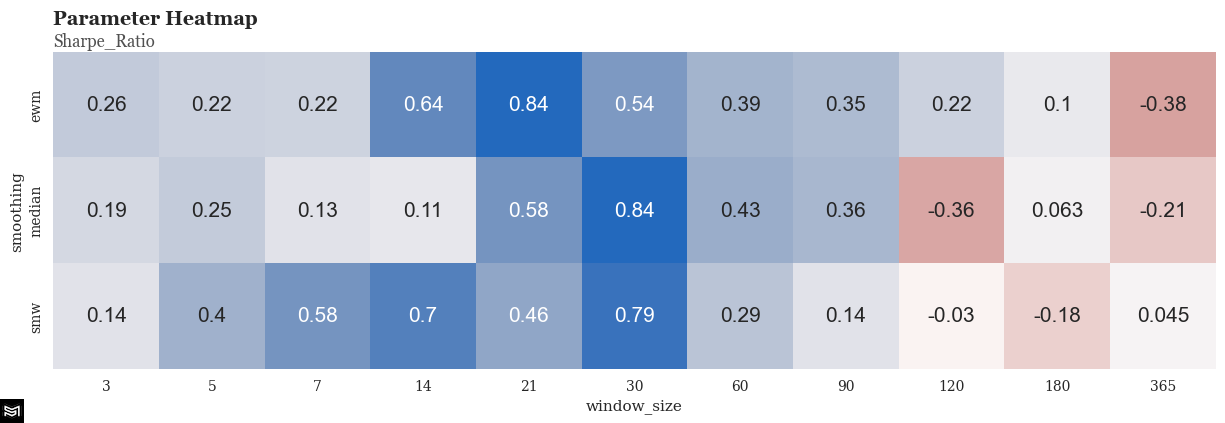

In [153]:
param_heatmap(nvm_cs_param_df, metric='sharpe_ratio', fixed_params={'log': True, 'method': 'ratio', 'act_users': 'add_new', 'norm': True}, plot_params=['smoothing', 'window_size'])

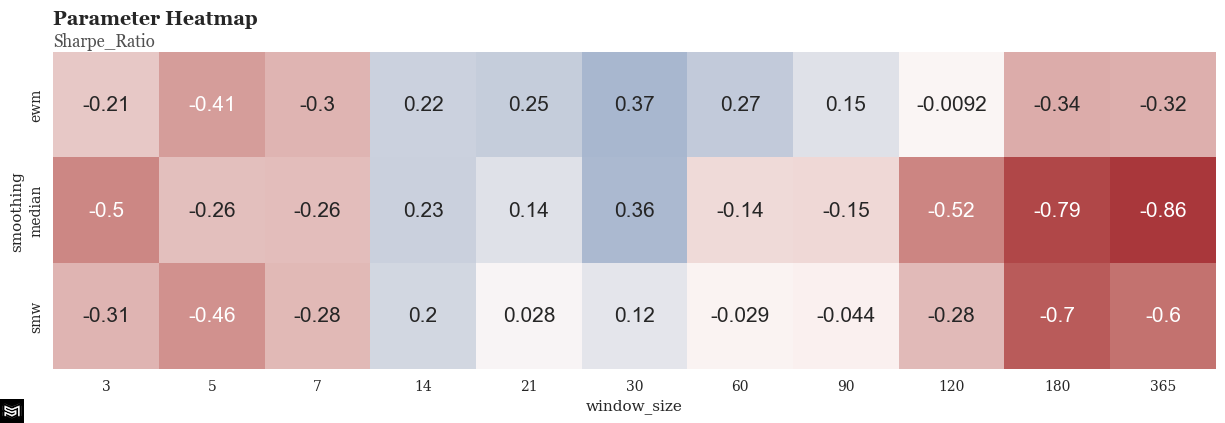

In [154]:
param_heatmap(nvm_cs_param_df, metric='sharpe_ratio', fixed_params={'log': True, 'method': 'lin_reg', 'act_users': 'add_new', 'norm': True}, plot_params=['smoothing', 'window_size'])

In [155]:
nvm_cs_param_h1_df = factor_param_grid_search(oc_df.loc['2016-01-01':'2019-12-31'], fwd_ret, Value, 'nvm',
                                feat_args = {
                                    'log': [True, False],
                                  'smoothing': ['smw','ewm','median'],
                                   'window_size': [3, 5, 7, 14, 21, 30, 60, 90, 120, 180, 365],
                                    'method': ['ratio', 'lin_reg']
                                },
                     algo_args = { 'act_users': ['add_act', 'add_new'],
                                  'norm': [True, False],
                                 },
                     factor_args = {'strategy': 'cs_ls', 'factor_bins': 5},
                     ret_args = {'signal_type': 'signal_quantiles', 'tails': 'two', 'cs_norm': True, 'rebalancing': 7, 't_cost': 0.002, 'weighting': 'iv'}
                               )

In [156]:
nvm_cs_param_h2_df = factor_param_grid_search(oc_df.loc['2020-01-01':], fwd_ret, Value, 'nvm',
                                feat_args = {
                                    'log': [True, False],
                                  'smoothing': ['smw','ewm','median'],
                                   'window_size': [3, 5, 7, 14, 21, 30, 60, 90, 120, 180, 365],
                                    'method': ['ratio', 'lin_reg']
                                },
                     algo_args = { 'act_users': ['add_act', 'add_new'],
                                  'norm': [True, False],
                                 },
                     factor_args = {'strategy': 'cs_ls', 'factor_bins': 5},
                     ret_args = {'signal_type': 'signal_quantiles', 'tails': 'two', 'cs_norm': True, 'rebalancing': 7, 't_cost': 0.002, 'weighting': 'iv'}
                               )

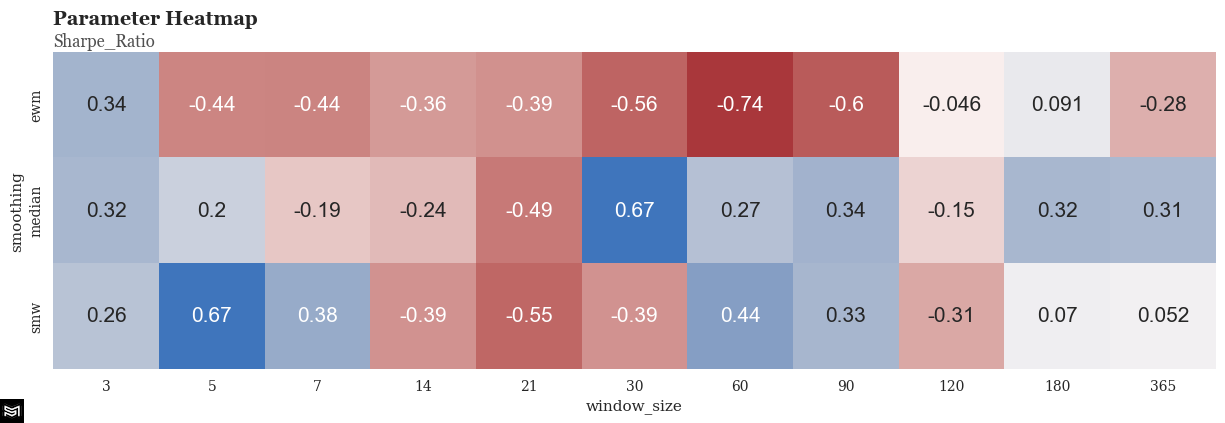

In [157]:
param_heatmap(nvm_cs_param_h1_df, metric='sharpe_ratio', fixed_params={'log': True, 'method': 'ratio', 'act_users': 'add_new', 'norm': True}, plot_params=['smoothing', 'window_size'])

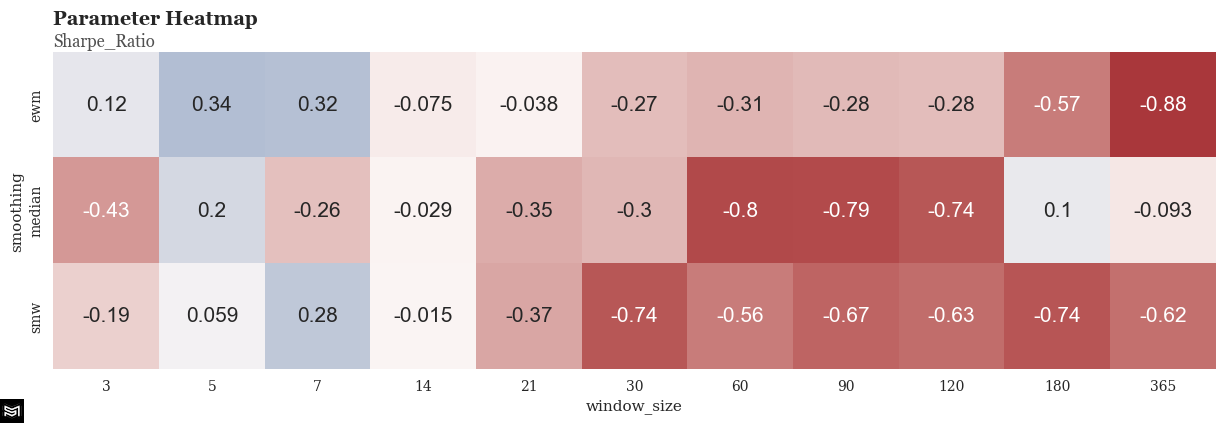

In [158]:
param_heatmap(nvm_cs_param_h2_df, metric='sharpe_ratio', fixed_params={'log': True, 'method': 'ratio', 'act_users': 'add_new', 'norm': True}, plot_params=['smoothing', 'window_size'])

### T-cost Analysis

Assessing the investability of a factor involves making sure that returns are positive after transaction costs. We can estimate the breakeven transaction cost for any factor using the `tcosts_be` method.

An investable value factor should produce positive returns after transaction costs with enough of a margin should t-costs increase.

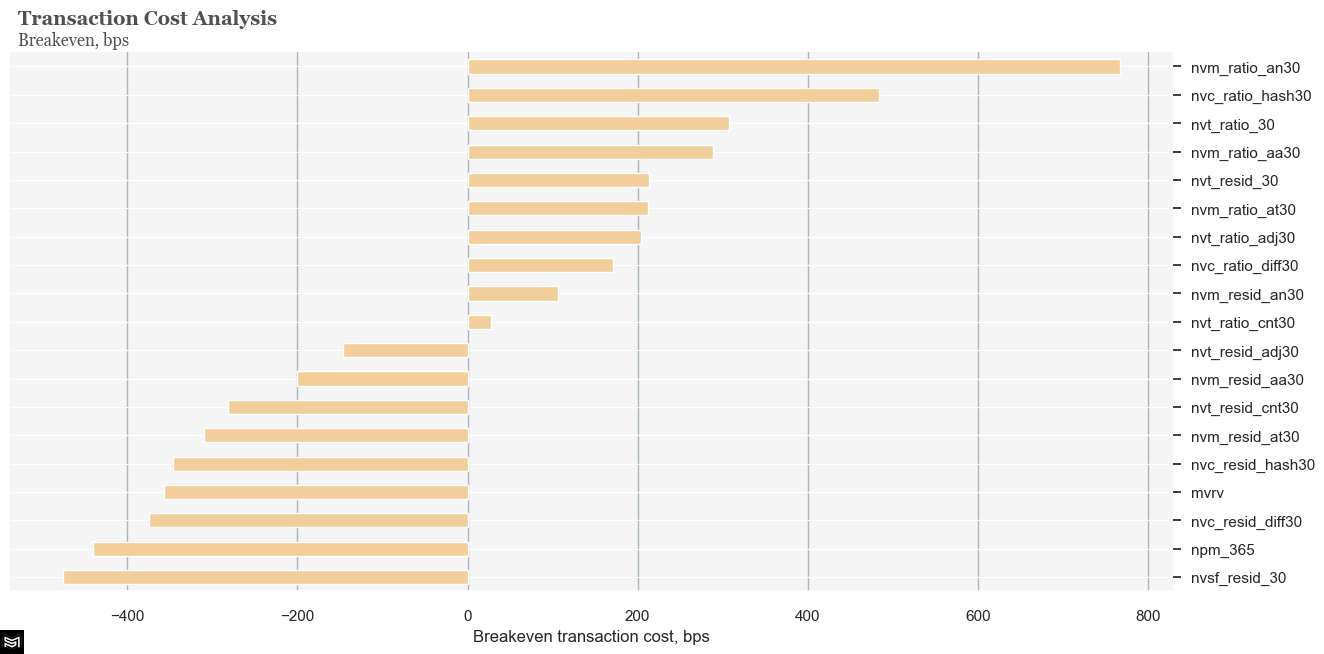

In [159]:
be_ts_tcosts = Factor(value_df, ret_df.tr, strategy='ts_ls', factor_bins=5).tcosts_be(signal_type='signal', rebalancing=7, weighting='iv', plot_tcosts=True)

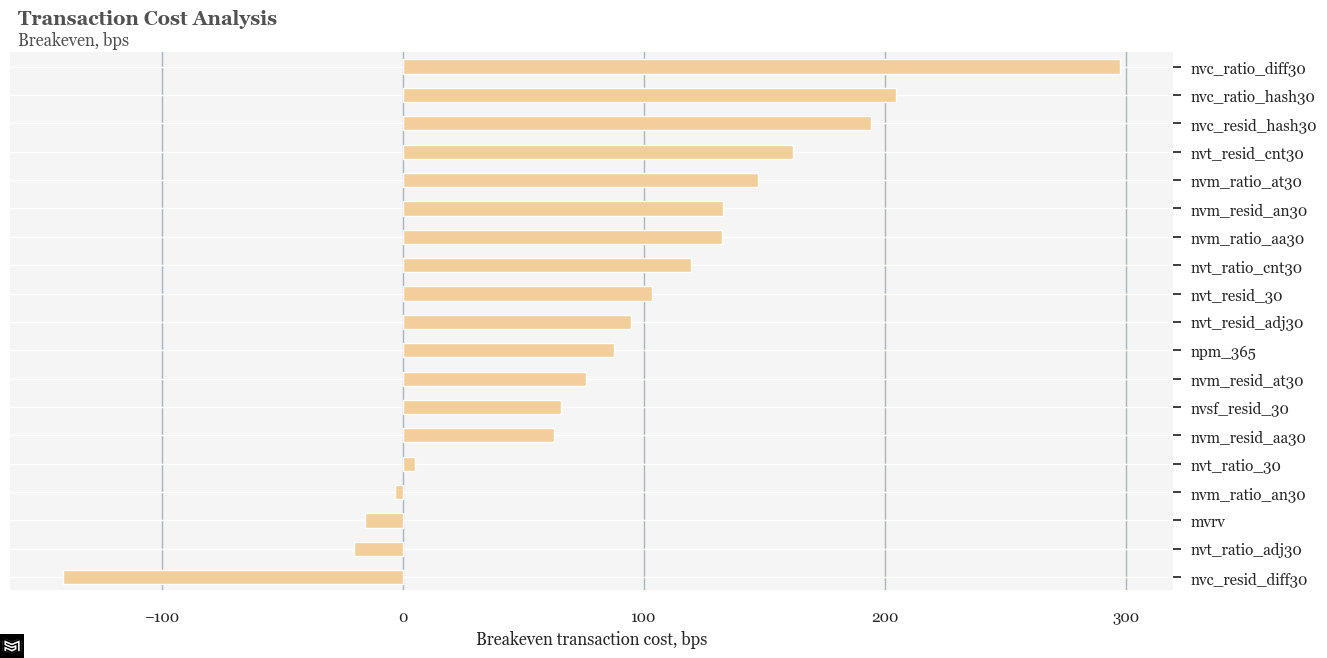

In [160]:
be_cs_tcosts = Factor(value_df, ret_df.tr, strategy='cs_ls', factor_bins=5).tcosts_be(signal_type='signal_quantiles', cs_norm=True, tails='two', rebalancing=7, weighting='iv', plot_tcosts=True)

# Value Everywhere

We can compare the cryptoasset value factor returns to those of individual equities (US, UK, EU, JP), global equity indexes, FX, global fixed-income and commodity value factors using AQR's Value & Momentum Everywhere returns:
<br>
https://www.aqr.com/Insights/Datasets/Value-and-Momentum-Everywhere-Factors-Monthly

In [161]:
aqr_df = pd.read_excel('https://www.aqr.com/-/media/AQR/Documents/Insights/Data-Sets/Value-and-Momentum-Everywhere-Portfolios-Monthly.xlsx', sheet_name='VME Portfolios', header=20, index_col=0, parse_dates=True)
aqr_df.index.name = 'date'

In [162]:
# create L/S value portfolios
aqr_df['US_Eqty_Value_LS'] = aqr_df.loc[:,'VAL3US'] - aqr_df.loc[:,'VAL1US']
aqr_df['UK_Eqty_Value_LS'] = aqr_df.loc[:,'VAL3UK'] - aqr_df.loc[:,'VAL1UK']
aqr_df['EU_Eqty_Value_LS'] = aqr_df.loc[:,'VAL3EU'] - aqr_df.loc[:,'VAL1EU']
aqr_df['JP_Eqty_Value_LS'] = aqr_df.loc[:,'VAL3JP'] - aqr_df.loc[:,'VAL1JP']
aqr_df['EQ_Value_LS'] = aqr_df.loc[:,'VAL3_VME_EQ'] - aqr_df.loc[:,'VAL1_VME_EQ']
aqr_df['FX_Value_LS'] = aqr_df.loc[:,'VAL3_VME_FX'] - aqr_df.loc[:,'VAL1_VME_FX']
aqr_df['FI_Value_LS'] = aqr_df.loc[:,'VAL3_VME_FI'] - aqr_df.loc[:,'VAL1_VME_FI']
aqr_df['COM_Value_LS'] = aqr_df.loc[:,'VAL3_VME_COM'] - aqr_df.loc[:,'VAL1_VME_COM']

In [163]:
value_ts_ret.columns

Index(['mvrv', 'npm_365', 'nvc_ratio_diff30', 'nvc_ratio_hash30',
       'nvc_resid_diff30', 'nvc_resid_hash30', 'nvm_ratio_aa30',
       'nvm_ratio_an30', 'nvm_ratio_at30', 'nvm_resid_aa30', 'nvm_resid_an30',
       'nvm_resid_at30', 'nvsf_resid_30', 'nvt_ratio_30', 'nvt_ratio_adj30',
       'nvt_ratio_cnt30', 'nvt_resid_30', 'nvt_resid_adj30',
       'nvt_resid_cnt30'],
      dtype='object')

In [164]:
# add crypto value factor
aqr_df['Crypto_Value_TS_LS'] = value_ts_ret[['nvm_ratio_aa30', 'nvm_ratio_an30', 'nvt_ratio_30', 
                                             'nvt_ratio_adj30', 'nvt_ratio_cnt30']].mean(axis=1).resample('M').sum()
aqr_df['Crypto_Value_CS_LS'] = value_cs_ret[['nvm_ratio_aa30', 'nvm_ratio_an30', 'nvt_ratio_30', 'nvt_ratio_adj30', 
                                             'nvt_ratio_cnt30']].mean(axis=1).resample('M').sum()
aqr_df['mkt_ret'] = mkt_ret_mw.resample('M').sum()

In [165]:
# target vol
aqr_norm_df = Transform(aqr_df).target_vol(ann_vol=0.1, ann_factor=12)

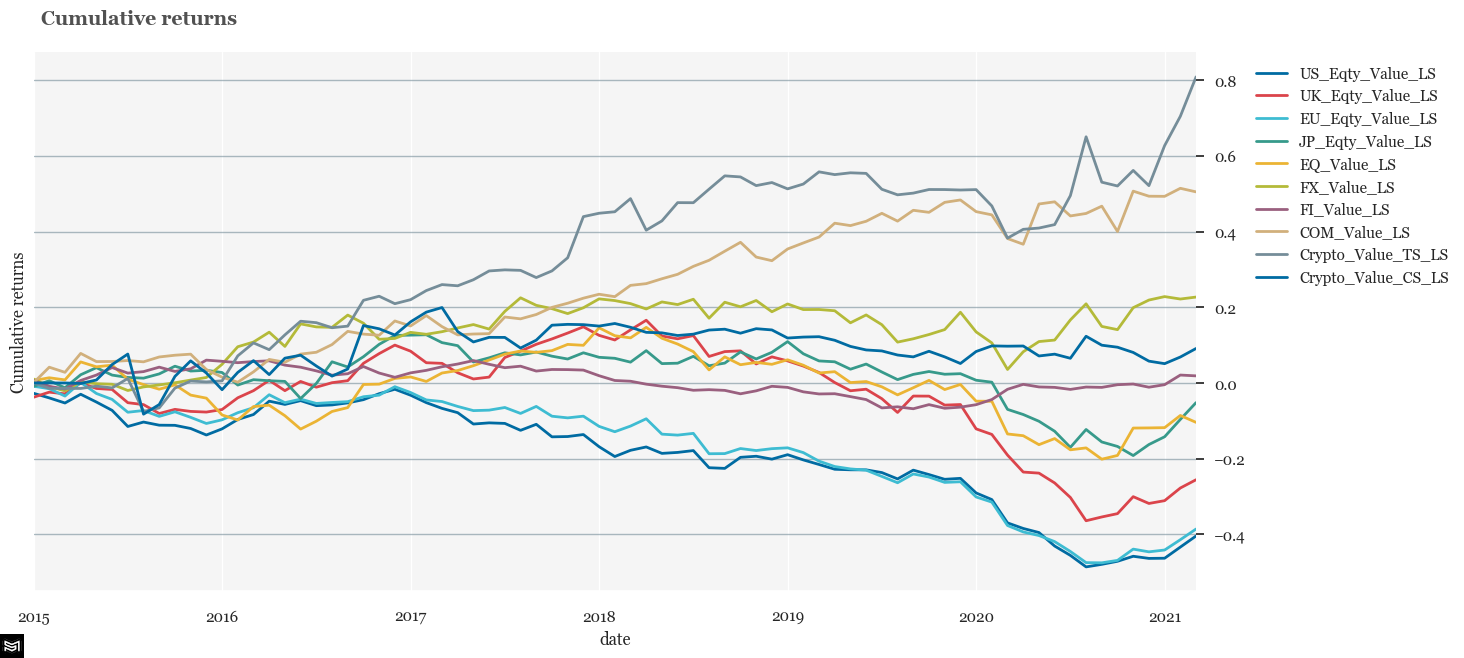

In [166]:
Performance(aqr_norm_df.loc[:,'US_Eqty_Value_LS':'Crypto_Value_CS_LS'].dropna(), mkt_ret=aqr_df.mkt_ret, ret_type='log').plot_metric()

In [167]:
value_table = Performance(aqr_norm_df.loc[:,'US_Eqty_Value_LS':'Crypto_Value_CS_LS'], mkt_ret=aqr_norm_df.mkt_ret, ann_factor=12).table(rank_on='Sharpe ratio', metrics='key_metrics')

In [168]:
value_table

Cumulative return  Annual return  Annual volatility  \
Crypto_Value_TS_LS               0.72           0.07                0.1   
JP_Eqty_Value_LS                 5.37           0.05                0.1   
EQ_Value_LS                      2.21           0.03                0.1   
FX_Value_LS                      2.02           0.03                0.1   
COM_Value_LS                     2.11           0.02                0.1   
EU_Eqty_Value_LS                 0.58           0.01                0.1   
FI_Value_LS                      0.50           0.01                0.1   
US_Eqty_Value_LS                 0.55           0.01                0.1   
UK_Eqty_Value_LS                 0.36           0.01                0.1   
Crypto_Value_CS_LS               0.03           0.00                0.1   

                    Max drawdown  Sharpe ratio  Calmar ratio  Stability  \
Crypto_Value_TS_LS         -0.11          0.77          0.65       0.88   
JP_Eqty_Value_LS           -0.47          0.50          0.10       0.91   
EQ_Value_LS                -0.51          0.32          0.05       0.53   
FX_Value_LS                -0.28          0.31          0.09       0.88   
COM_Value_LS               -0.42          0.27          0.05       0.67   
EU_Eqty_Value_LS           -0.64          0.16          0.02       0.43   
FI_Value_LS                -0.38          0.15          0.03       0.64   
US_Eqty_Value_LS           -0.56          0.14          0.02       0.25   
UK_Eqty_Value_LS           -0.58          0.13          0.01       0.34   
Crypto_Value_CS_LS         -0.16          0.09          0.03       0.01   

                    Annual alpha  Alpha p-val  Beta  Beta p-val  
Crypto_Value_TS_LS          0.05         0.16  0.25        0.00  
JP_Eqty_Value_LS           -0.00         0.96 -0.07        0.30  
EQ_Value_LS                -0.04         0.16  0.16        0.06  
FX_Value_LS                 0.00         0.92  0.15        0.06  
COM_Value_LS                0.04         0.08  0.02        0.78  
EU_Eqty_Value_LS           -0.05         0.06 -0.05        0.53  
FI_Value_LS                -0.01         0.38  0.04        0.29  
US_Eqty_Value_LS           -0.03         0.24 -0.11        0.14  
UK_Eqty_Value_LS           -0.04         0.20 -0.04        0.68  
Crypto_Value_CS_LS          0.01         0.88  0.04        0.68

In [169]:
publish_table(value_table, title='Performance - Value Everywhere', reset_index=True)

In [170]:
corr_df = aqr_df.loc[:,'US_Eqty_Value_LS':].corr()

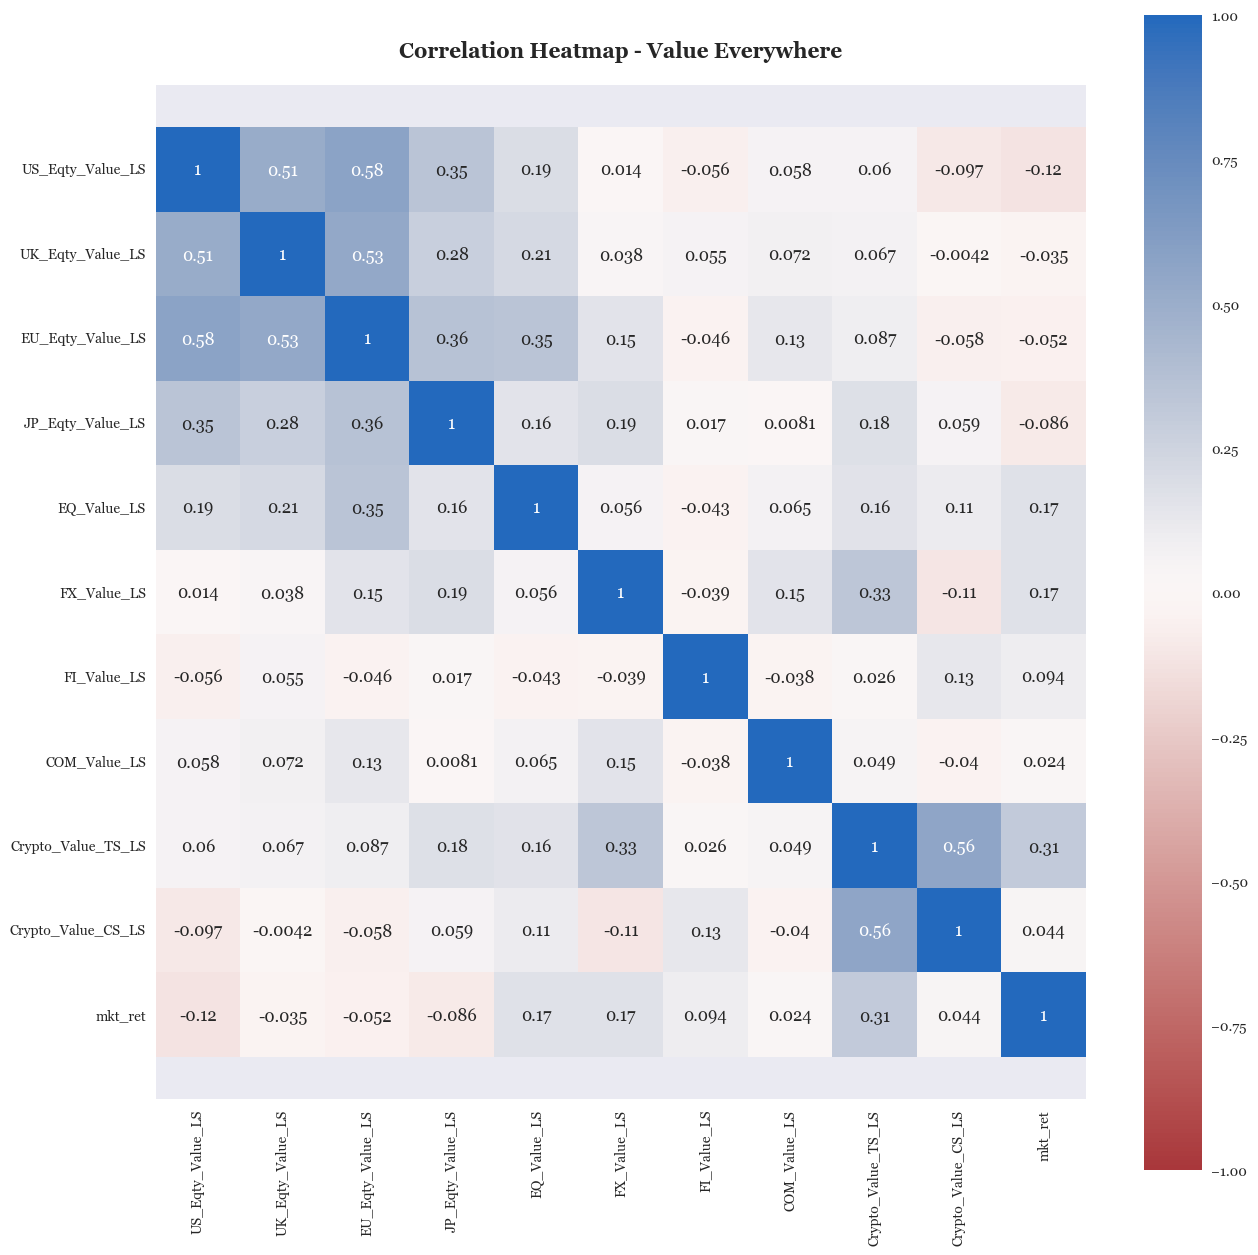

In [171]:
# create correlation heatmap
# set plot style, font and colors
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'georgia'
fig = plt.figure(figsize=(15,15))
sns.despine(left=True)

heatmap = sns.heatmap(corr_df, cmap="vlag_r", annot=True, vmin=-1, vmax=1, xticklabels=corr_df.columns, yticklabels=corr_df.columns, square=True)
heatmap.set_title('Correlation Heatmap - Value Everywhere', fontdict={'fontsize':15}, pad=20, weight='bold')
bottom, top = heatmap.get_ylim()
heatmap.set_ylim(bottom + 0.5, top - 0.5);

# Market Valuation

In [172]:
# market ret and NVM ratio
mkt_value_df = value_z_df[['nvm_ratio_an30']].mean(axis=1).groupby('date').mean().to_frame('NVM_ratio')
mkt_value_df = pd.concat([mkt_value_df, mkt_ret_mw.cumsum()], axis=1).replace(0, np.nan).dropna()

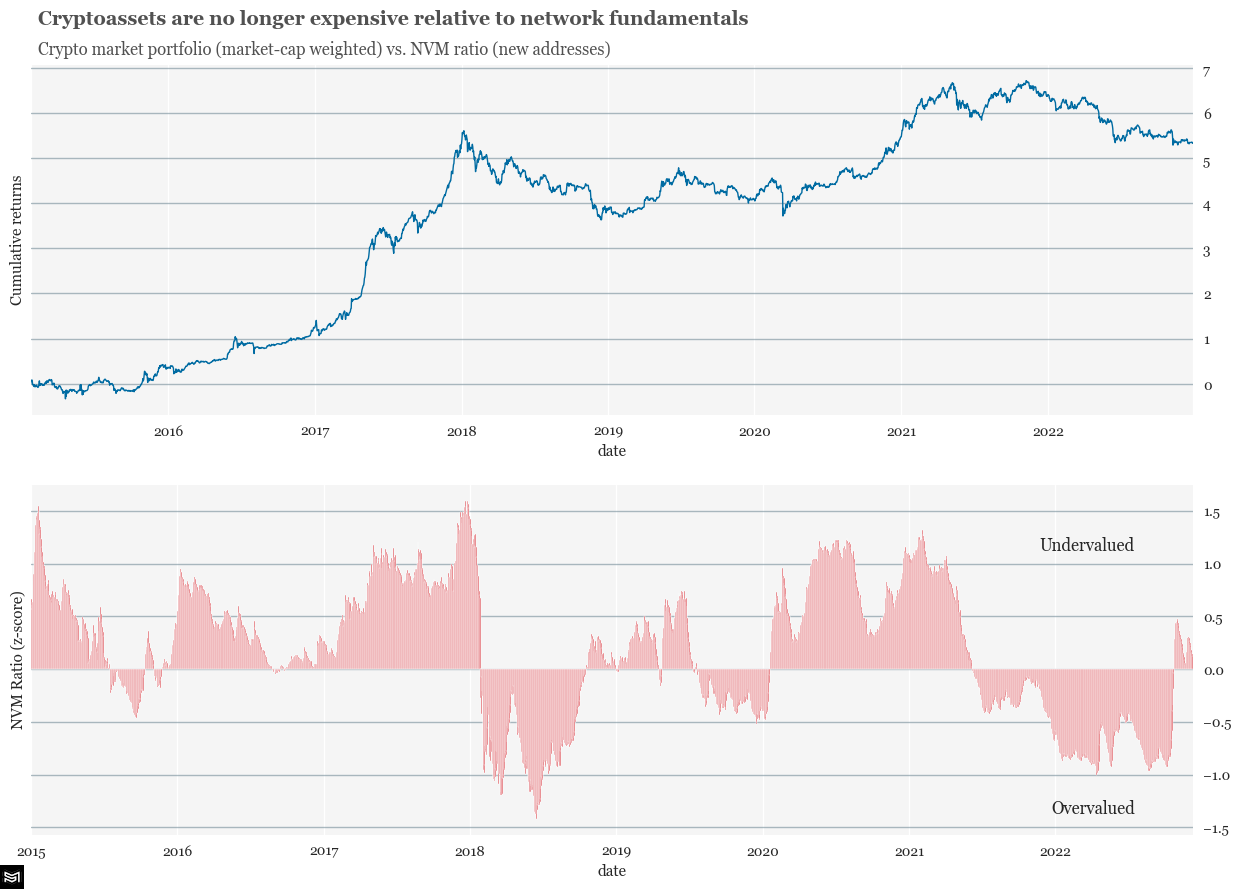

In [173]:
# plot market ret and NVM ratio
fig, axes = plt.subplots(nrows=2, figsize=(15,10))

mkt_value_df['mkt_ret'].plot(
    linewidth=1,
    color='#006BA2',
    ax=axes[0])

mkt_value_df['NVM_ratio'].plot(
    kind='bar', 
    ax=axes[1], 
    width=2,
    color='#DB444B')

# font
plt.rcParams['font.family'] = 'georgia'

# grid
for i in range(0,2):
    axes[i].grid(which="major", axis='y', color='#758D99', alpha=0.6, zorder=1)
    axes[i].set_facecolor("whitesmoke")
    axes[i].spines[['top', 'right', 'left']].set_visible(False)
    
# Reformat y-axis tick labels
axes[0].set_ylabel('Cumulative returns')
axes[0].yaxis.tick_right()
axes[1].set_ylabel('NVM Ratio (z-score)')
axes[1].yaxis.tick_right()

# add systamental logo
img = Image.open('../src/factorlab/systamental_logo.png')
plt.figimage(img, origin='upper')

# Add in title and subtitle
axes[0].text(x=0.13, y=.92, s=f"Cryptoassets are no longer expensive relative to network fundamentals", transform=fig.transFigure, ha='left', fontsize=14,
        weight='bold', alpha=.8, fontdict=None)

sub_title = f"Crypto market portfolio (market-cap weighted) vs. NVM ratio (new addresses)"
axes[0].text(x=0.13, y=.89, s=sub_title, transform=fig.transFigure, ha='left', fontsize=12, alpha=.8,
        fontdict=None);

# show every Nth label
locs, labels = plt.xticks()
N = 365
plt.xticks(locs[::N], mkt_value_df.index[::N].strftime('%Y'), rotation=0)

# add over/undervaluation text
axes[1].text(0.95, .8, 'Undervalued', horizontalalignment='right', verticalalignment='bottom', transform=axes[1].transAxes)
axes[1].text(0.95, .05, 'Overvalued', horizontalalignment='right', verticalalignment='bottom', transform=axes[1].transAxes);

In [174]:
# market value comp
value_comp_z_df = value_z_df[['nvm_ratio_an30']].mean(axis=1)
mkt_value_comp_z_df = value_comp_z_df.groupby('date').mean().to_frame('NVM_ratio')
mkt_value_comp_z_df['ticker'] = 'crypto_mkt'
mkt_value_comp_z_df = mkt_value_comp_z_df.reset_index().set_index(['date', 'ticker'])

In [175]:
# fwd mkt rets
fwd_mkt_ret = fwd_spot_ret.groupby('date').mean()
fwd_mkt_ret['ticker'] = 'crypto_mkt'
fwd_mkt_ret = fwd_mkt_ret.reset_index().set_index(['date', 'ticker'])

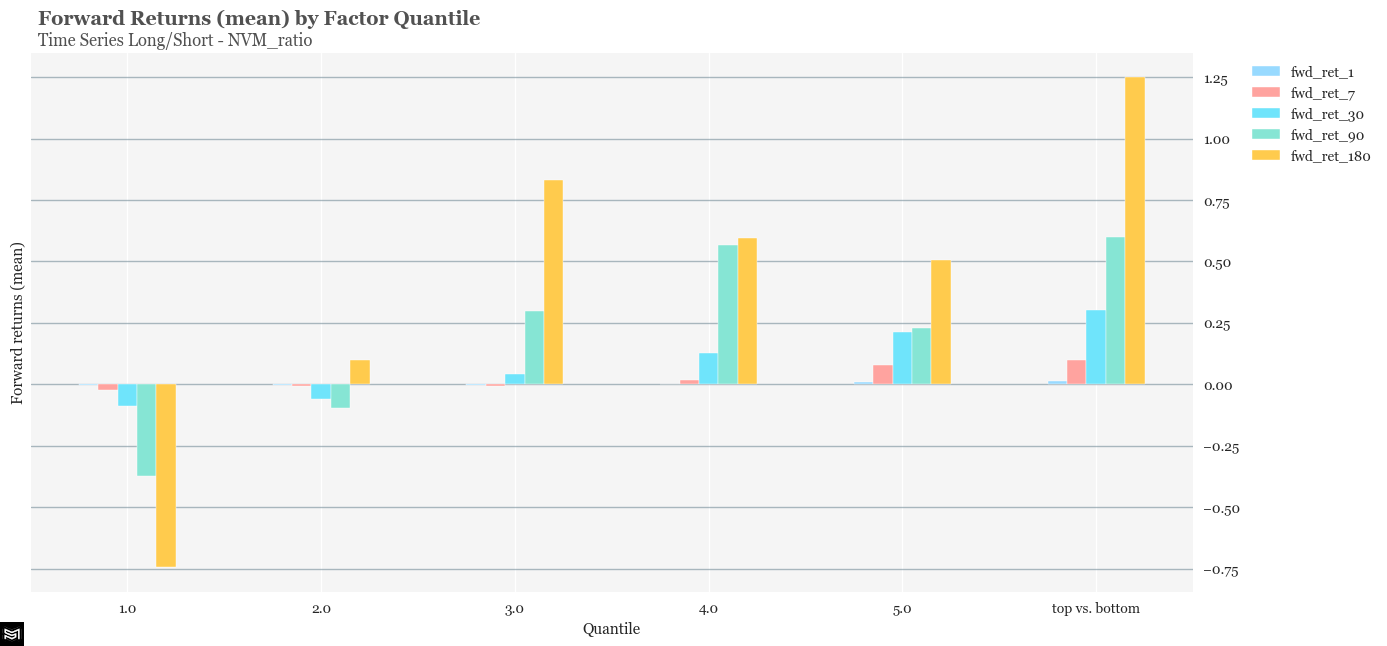

In [176]:
quantile_ts_ret = Factor(mkt_value_comp_z_df, fwd_mkt_ret[['fwd_ret_1', 'fwd_ret_7', 'fwd_ret_30', 'fwd_ret_90', 'fwd_ret_180']], strategy='ts_ls').ret_quantiles(factor='NVM_ratio', plot_rets=True)

# Crypto Valuation Dashboard

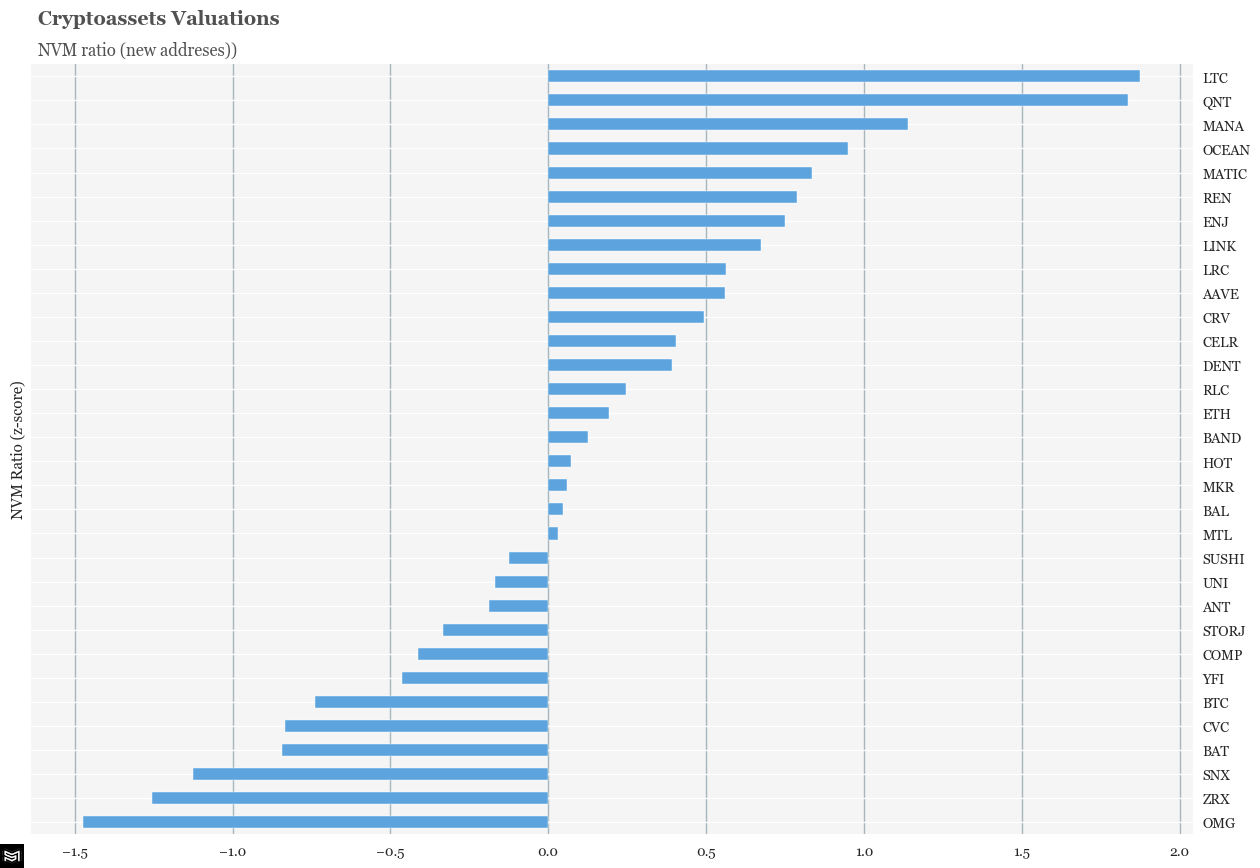

In [177]:
fig, ax = plt.subplots(figsize=(15,10))

value_comp_z_df.unstack().iloc[-1].dropna().sort_values().plot(kind='barh', figsize=(15,10), color='#5DA4DF')

# font
plt.rcParams['font.family'] = 'georgia'

# grid
ax.grid(which="major", axis='x', color='#758D99', alpha=0.6, zorder=1)
ax.set_facecolor("whitesmoke")
ax.spines[['top', 'right', 'left']].set_visible(False)
    
# Reformat y-axis tick labels
ax.set_ylabel('NVM Ratio (z-score)')
ax.yaxis.tick_right()

# add systamental logo
img = Image.open('../src/factorlab/systamental_logo.png')
plt.figimage(img, origin='upper')

# Add in title and subtitle
ax.text(x=0.13, y=.92, s=f"Cryptoassets Valuations", transform=fig.transFigure, ha='left', fontsize=14,
        weight='bold', alpha=.8, fontdict=None)

sub_title = f"NVM ratio (new addreses))"
ax.text(x=0.13, y=.89, s=sub_title, transform=fig.transFigure, ha='left', fontsize=12, alpha=.8,
        fontdict=None);